<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [6]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [7]:
import tensorflow_probability as tfp

In [8]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50'+'_8_fully_connected_mean_div'

seed            = 8720

latent_dim      = 8
network_type    = 'fully_connected'

In [9]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [10]:
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))

In [11]:
test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))

In [12]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder = tf.keras.models.load_model(path)

In [13]:

encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)
decoded_train,decoded_valid, decoded_test, mean = np.load(os.path.join(root_decoded,'decoded_%s.npy'%label_2), allow_pickle=True)

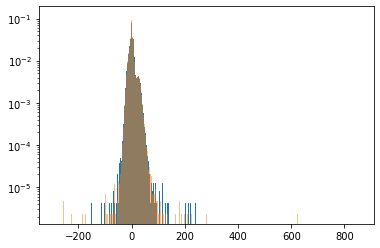

In [14]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [15]:
len(encoded_valid)

47133

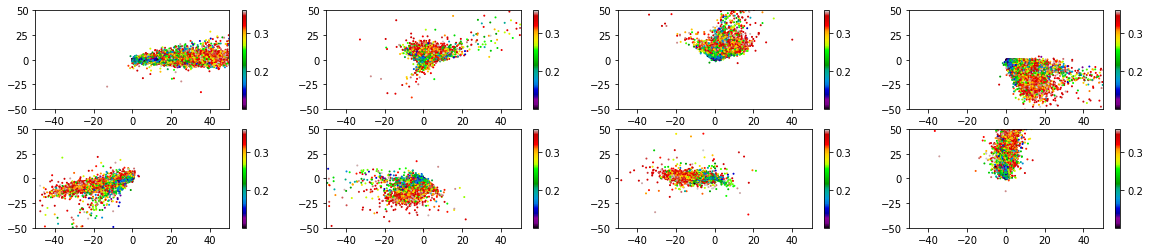

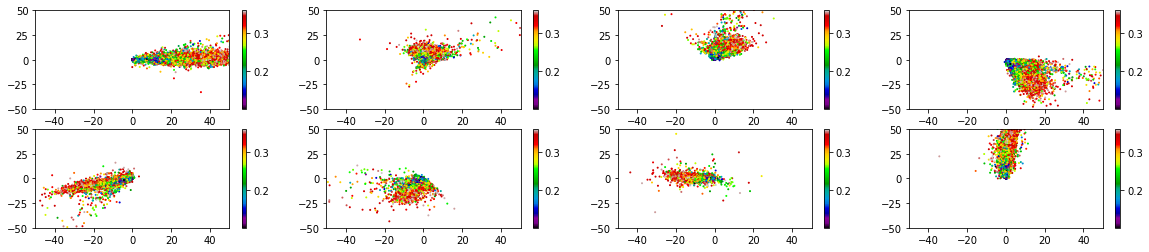

In [16]:
lims = 50

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_data['arr_3'], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_test[:47000,ii],encoded_test[:47000,jj],c=test_data['arr_3'], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(valid_data['arr_7'])
print(le.classes_, le.transform(le.classes_))

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


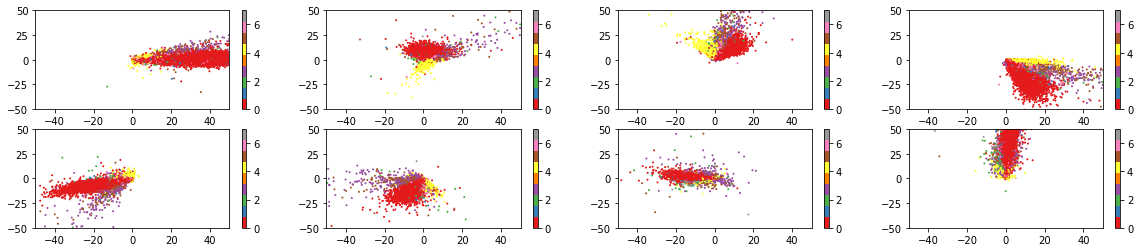

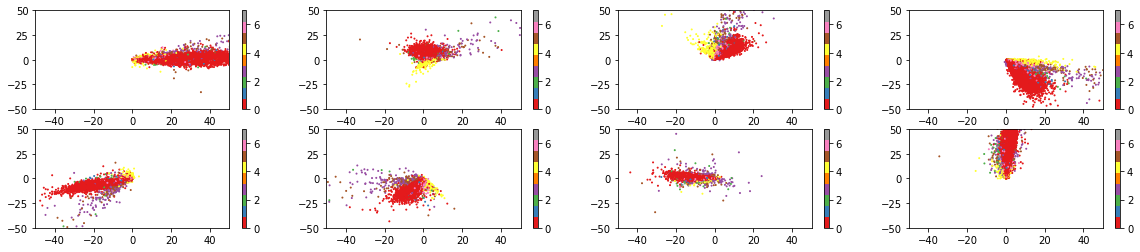

In [18]:
lims = 50

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=le.transform(valid_data['arr_7']), cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_test[:47000,ii],encoded_test[:47000,jj],c=le.transform(test_data['arr_7'])[:47000], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [19]:
mean = 239580.16070643716

In [20]:
np.where(valid_data['arr_1'])

(array([    0,     0,     0, ..., 47132, 47132, 47132]),
 array([  0,   1,   2, ..., 903, 904, 905]))

In [44]:
res = (np.squeeze(decoded_valid)-valid_data['arr_0'])**2

In [48]:
ma_res = np.ma.array(res, mask=valid_data['arr_1'])

In [54]:
recon_errors = ma_res.mean(axis=1)

In [57]:
ind = np.argsort(recon_errors.data)

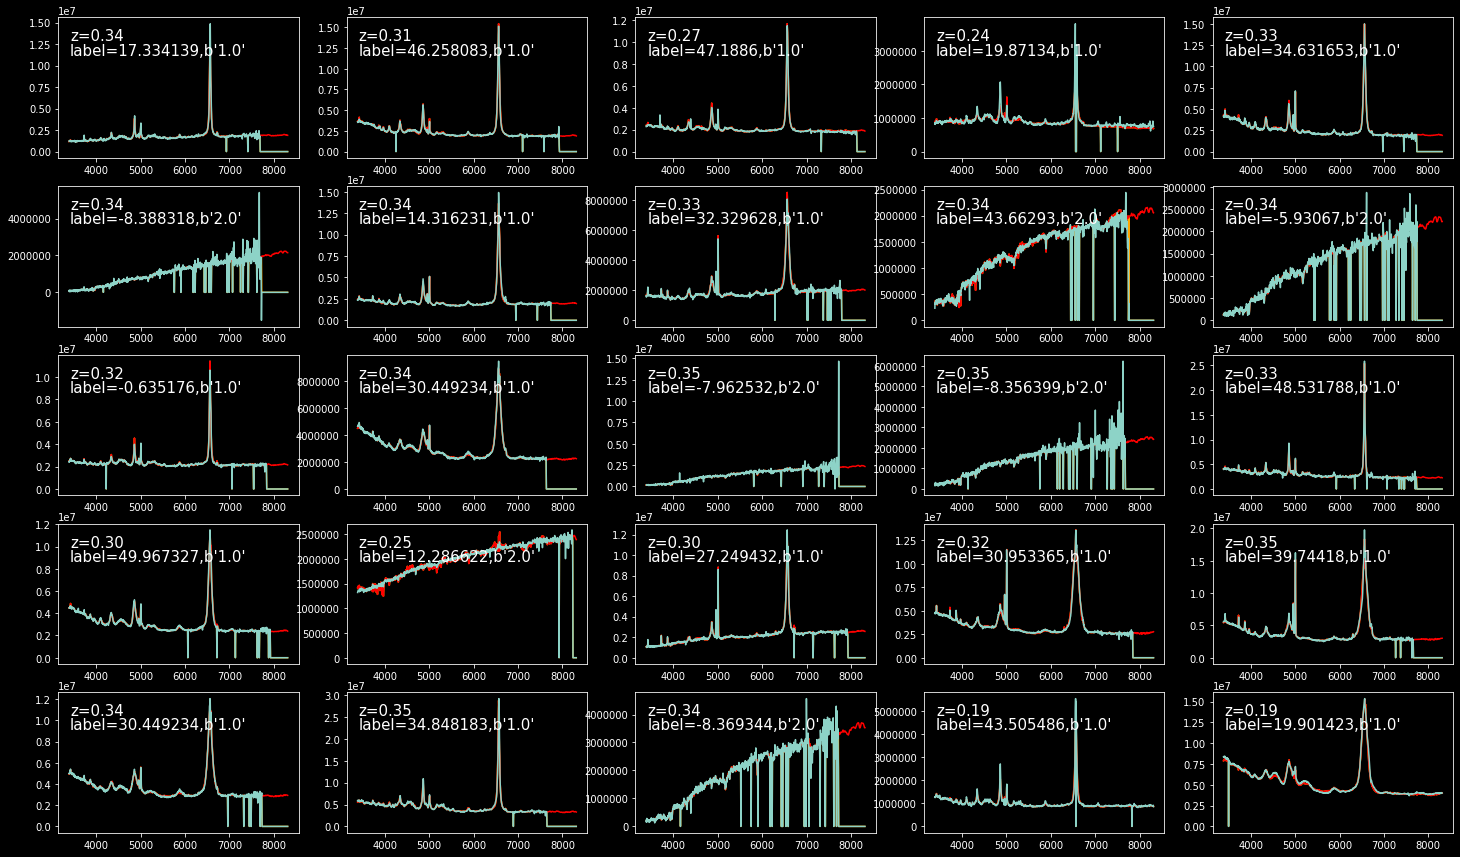

In [61]:
## largest reconstruction error
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(ind[-25::]):
                
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]*mean)*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]*mean), color='red')
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii]*mean))#*np.squeeze(valid_data['arr_1'])[ii], )
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid_data['arr_5'][ii],valid_data['arr_6'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

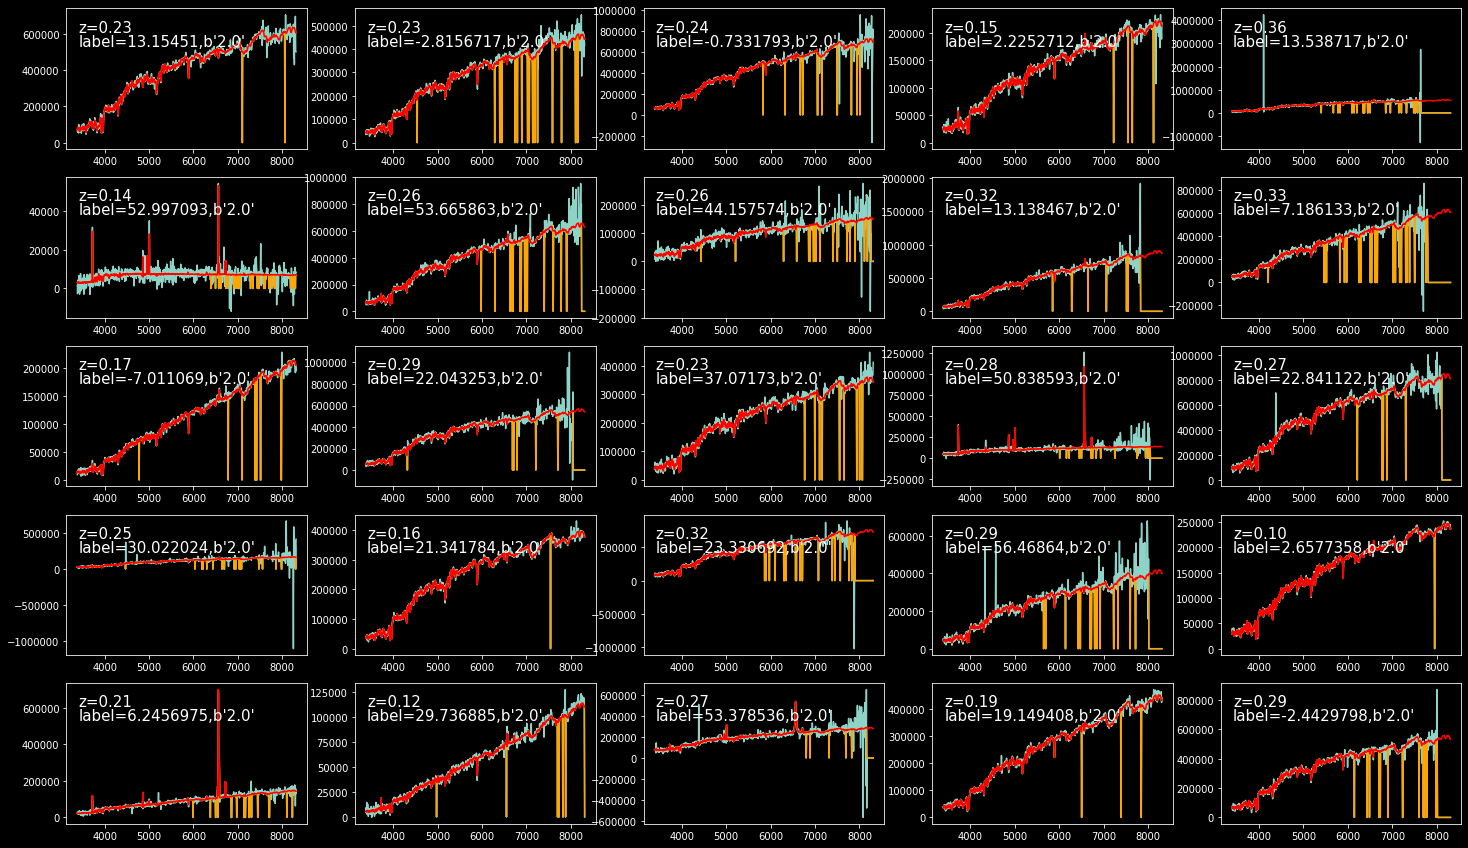

In [24]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii]*mean)*np.squeeze(valid_data['arr_1'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]*mean)*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]*mean), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid_data['arr_5'][ii],valid_data['arr_6'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

In [31]:
enc = encoder.predict(train_data['arr_0'])

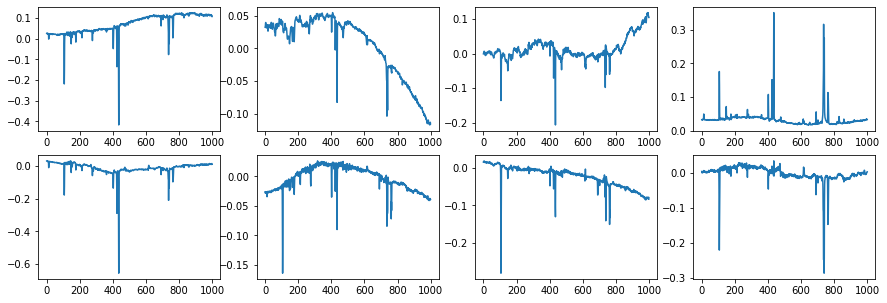

In [35]:
sens=[]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]+=1
    sens+=[res]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]-=1
    sens+=[res]
sens+=[np.mean(enc,axis=0)]
sens = np.asarray(sens)
test = decoder.predict(sens)

fig, ax = plt.subplots(2,latent_dim//2, figsize=(15,5))
ax = ax.flatten()
for ii in range(latent_dim): 
    ax[ii].plot(test[ii]-test[latent_dim+ii])
plt.show()

In [21]:
root_outliers   = '/global/cscratch1/sd/vboehm/SDSSOutlier'

logp = np.load(os.path.join(root_outliers,'valid_test_logps.npy.npz'), allow_pickle=True)

In [39]:
ind = np.argsort(logp['arr_0'])

In [40]:
ind1=ind[0:20]

ind2=ind[20:40]

ind3=ind[40:50]

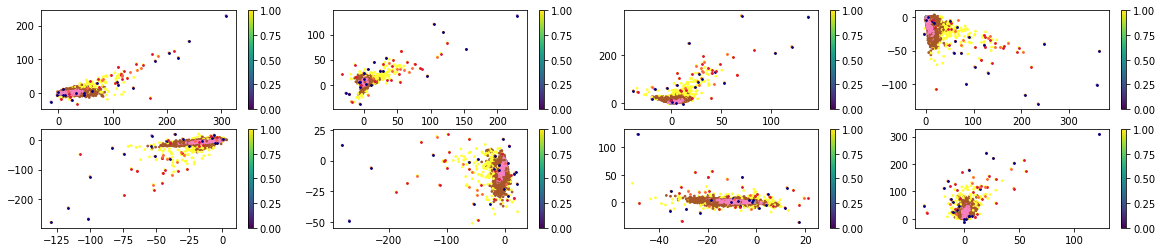

In [41]:
fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
#lims =300
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=logp['arr_0'], cmap='Set1', s=3)
    im = ax[ii].scatter(encoded_valid[ind1,ii],encoded_valid[ind1,jj],color='navy', s=3)
    im = ax[ii].scatter(encoded_valid[ind2,ii],encoded_valid[ind2,jj],color='crimson', s=3)
    im = ax[ii].scatter(encoded_valid[ind3,ii],encoded_valid[ind3,jj],color='tomato', s=3)
    plt.colorbar(im, ax=ax[ii])
#     ax[ii].set_xlim(-lims,lims)
#     ax[ii].set_ylim(-lims,lims)
plt.show()

# fig, ax = plt.subplots(2,4, figsize=(20,4))
# ax=ax.flatten()
# for ii in range(latent_dim):
#     jj= (ii+1)%latent_dim
#     im = ax[ii].scatter(encoded_test[:,ii],encoded_test[:,jj],c=logp['arr_1'], cmap='Set1', s=3)
#     plt.colorbar(im, ax=ax[ii])
# #     ax[ii].set_xlim(-lims,lims)
# #     ax[ii].set_ylim(-lims,lims)
# plt.show()

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()XJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nOzdd3xUVdrA8d+ZSSWBYagaEokF+xoVVAQ1YBej6FpedXXE1QD2MmJbHTV2Mbrq2oiyOvZdK0Z2LaixuxRBUUBRAoRQZRha2syc949zQyYhnUlmJnm+n8/dJLecOROzD3Ofe85zlNYaIYQQQgghhBBCCCFs0e6AEEIIIYQQQgghhIgNkigSQgghhBBCCCGEEIAkioQQQgghhBBCCCGERRJFQgghhBBCCCGEEAKQRJEQQgghhBBCCCGEsEiiSAghhBBCCCGEEEIAkigSQjSglJqqlFqjlJrfxHGllHpMKbVYKfWDUurgsGMXKqV+tbYLO6/XQoiuRmKRECIWSCwSQsSCzo5FkigSQjT0PHBiM8dPAoZY23jgKQClVB/gduAw4FDgdqWUs0N7KoToyp5HYpEQIvqeR2KRECL6nqcTY5EkioQQ9WitPwfWN3PKWMCrjW+B3kqpnYETgI+01uu11j7gI5oPZkII0SSJRUKIWCCxSAgRCzo7FiVEotMdrV+/fjo7Ozva3RAi6mbPnr1Oa92/teefMDpN/7E+WL+NH6p+AirDdk3RWk9pQzcGAcvDfi6z9jW1v0uReCSExKJYILFICIlFsUBikRBdMxbFRaIoOzubWbNmRbsbQkSdUmppW85ftz7Idx9k1tuXuPNvlVrrYTvSjUb26Wb2dykSj4SQWBQLJBYJIbEoFkgsEqJrxiKZeiZEF6bRVOmaelsElAFZYT9nAuXN7BdCdHMSi4QQsUBikRAiFsRDLJJEkRBdmEZTo0P1tgiYBrisyvrDAb/WeiXwAXC8UsppFUg73tonhOjmJBYJIWKBxKLYtey7D5n7SiGV/uZKsAjRNcRDLIqLqWdCdFWhYIjvvN8TrAlx+EUHY0+0R7Z9oFIHWzwvnFLqVWAU0E8pVYapkp8IoLV+GpgOjAEWA1uBi6xj65VSdwEzraYKtNbyr70QcUBrzdy3fmbDCj+HXzSUlJ7JEW1fYpEQLVj2FXzzMAy/BgYfGe3edFkSi1qmlDoReBSwA89qre/v6NdcX7qAr/9+HToU5NcPX+OMZ79Go7HZE1GqsVkzQsS3eIhFkigSIoqWf1/OU0/8j+Kf13Pdr+u5dfIJEW1fa02lbtt0eK31uS0c18DlTRybCkxt0wsKIaJuQ9lGHrnnc4oX/MFlP63j7mdOjWj7EouEaMHbLoo+7k3BhPfwTO5Bfv7QaPcoav4o9bF28R/scWQ2CcmRvVWRWNQ8pZQdeAI4DjNdZaZSaprW+ucdbXvKfVNIT7Fz6KY0tqz5ifKNM6kKbKYi+Ee98wIVm/nsgctY/eNXODJ35aTJ+6HUauAOIADsQeMlV4SIH/EQi2TqmRBR1Hewk+Kf1+OrCPDUy/Mj3r5GUdNgE0KIhtL79eD9RevxVQaZ+u4vEW9fYpEQLRgyhoLPcynzp1FQ8Hm0exM1geog1575GiNOfZ1bLnkn4u1LLGrRocBirfXvWutq4DXMkts7ZMojU9jX7mD/mr68PbuKMd5U/rficIJUYVfbj2Bd/cOXoDUJKaXAZ8BCYBxwAfD0jnZHiKiLh1gkiSIhoii9fxr3PXwCmYN6csedoyLevhnWaKu3CSFEQ4mpidxrxaI77xod8fYlFgnRgjGP47n/LDIze+HxHBXt3kSNsqltD9BemP5bxNuXWNSiVi2jrZQar5SapZSatXbt2pZbTYQNKTXsUeng0c/KKd9UwzMzbQRCVWiars3iKw3hW1rD5jUBtN6CGVH0YVvfkxAxJx5ikUw9EyLKJkwcxoSJO7ISYtM0UBODgUcIEXsmTBjGhAkSi4SIlvxLDyf/0sOj3Y2osifYKLjnaO594KsOeYAmsahFrVpGW2s9BZgCMGzYsGbnz+hQiBErEvhhUCUazS25g7m3ZCk35WaRkuAgLXEAaM3aigXbXRuqgQ9urATgyOt7knmIDTikHW8LTJIpAKS083ohIiceYlFs904IsUNCKCp1Qr1NCCE6m8QiIURrXXHt4ZSvup7xHZC4lljUonYto92cyo3rWb3Sy6JPFHsVfodG84t7OOcekEplzQb6pu1G+vIKcr5y0n9F4wsp9OgPG1eeCDwI3ND4C318Czw7AtYubOSgH0rGwKRToeTZHXk7QkREPMQiSRQJ0YVpFDU6od4mhBCdTWKRECIWSCxq0UxgiFJqV6VUEnAOZsntdkvt3Y/N9nVMmbGaFRurua9kGSFClPq+omfKTrz1UxKhuTUkV9nJKO3RaBv9htjY68T3Wfa/3zETYjawdtG3fP7gZfzx22tQ8QVFj31E1vXDKXryfmBOgxZWQDHgs0Hx9B15O0JERDzEIkkUCdGFaR372WohRNcnsUgIEQskFjVPax0ArgA+ABYA/9Ja/7Sj7WbmHsINuZlk9Eri5txdsGNj3wGn8KeBZ/HMTBuPbtmV1aEkyrO3bn+xghSHDZUA/qVPsGnVNOAkvnvqEio3ltA76yFIuYmCb4+lzO+g4OkBmIWfqsIa2QfyDgFnEuS5dvTtCLHD4iEW7XCPlFJZgBfYCVOXaYrW+lGlVB/gdSAbKAXO1lr7lFIKeBQYA2wFxmmtG6Z9hRARYIY1JkW7G0J0nLLvINkB/feOdk9EMyQWCSFigcSilmmtpwMRHXaTPeJadv1tBeOHZWK3xiloNP3S9uCyQ1fy+Ld9WJFew4I5wzi9cj7H7P57WIdg4P6KzSs1S7/ZwpLP76X3LltISAmx66gEbImgqeK2q+cx56E+XJlQiv/5EI5xt2Kmqimz5d4DuZF8V0K0XzzEokiMKAoAbq31PsBw4HKl1L7ATcAMrfUQYIb1M8BJwBBrGw88FYE+CCEaoVFUa3u9TYguY+E0ii6/mqw9iih65L/R7o1ohsQiIUQskFgUHal9BhIMVACgdV3ta43mrP1D/OOUaSxYO5D1FT14++f9t7v+i8k1vH9dBQP3UxxXUE3WYTb8yzV7HJOIUqal/PxSbur9CymVCt8jCcBnwJbOeHtCtFk8xKIdThRprVfWjgjSWm/CDFMcBIwFXrBOewE4zfp+LODVxrdAb6XUzjvaDyHE9kIoKkOJ9TYhuozqTRR8NpKyjb0oeOiHaPdGNENikRAiFkgsio7knk5WbpxD7QJqgWANgVAVazYt5IfVbwJw+r7z6ZO6ldP3nV/vWmUDZQd7Mux5UhKpThvZR5iRRCtmBdEhTU0F6L6pOK+txj4wiNMdAP4PSG9lD2cDbwLVEXrHQjQvHmJRRCfDKaWygYOA74CBWuuVYJJJSqkB1mmDgOVhl5VZ+1ZGsi9CCNCamCyOJkRE/Ok8PNduoWDKejx3HBPt3ohmSCwSQsQCiUXRYU9MYtXmHxnS7xhAY7clAAkM7LkPRwy+ikXr/sMxuy/kmD1+J7U3VPjqru3RD/rsZifVCWsXBEjpaSMhGfIeSQW75vuXqvjlP0F2H53AoKPsZF9VDfQCLsMkpoqAVzHzziYBaQ16tw640vp+A3BxR/4qhADiIxZFrJi1Uiodk4q9Rmu9sblTG9mntztJqfFKqVlKqVlr166NVDeF6FY0ikqdWG8TostQivw7xrO8/Cby84dGuzeiGRKLhBCxQGJRtAToP7Kx+zlFv7QhjBh8OX3SduPw/dLI+aoPe6amkNrHjCTqu4eNFbOCLP44yMwpAd65bCu2REh12kjpaeOg85PpPVjx++cBbIm1t5nPYIpZnwiBpyl6ykFWZiVFT96JqZpSDPxonZsCJGJuUft08O9BCCMeYlFE0lhKqURMkuhlrfVb1u7VSqmdrdFEOwNrrP1lQFbY5ZlAecM2tdZTgCkAw4YN2y6RJIRoWQhFVQwOZRRCdC8Si4QQsUBiUTR8DtyHc/cagssD1mii+hR2CNoIvpIC6xSOr3uQM9/Gqh+CfPN4FaHAthNJSIBAFSQka5RSaDTH3pFC1Wbo0bc2UTQT+C/wB6yvouDuvSgrT6Xg7hryL3sReBYzTqEYkxy6H7gOeBoYDfTu0N+IEPEQi3Z4RJG1itlzwAKt9cNhh6YBF1rfXwi8G7bfpYzhgL92ipoQIrI0ihptr7cJIURnk1gkhIgFEoui4TlgLWk7B9lUtd3YAItmkONglvTdTFVykNIBW5g+aStf/b2KQCXY7HDIhCSOuCYZewpsWBY0V2nNxhftlB2WSmB6AhtftFOak4zf+yiwEK1B903htlN+JLNvBZ4bj8RUQKnGjCCaDxyDWZAbzNSzM6grsytEx4iHWBSJEUUjgQuAH5VSc619t2BSs/9SSl0MLAPOso5NB8YAi4GtwEUR6IMQohFaq5gsjiaE6F4kFgkhYoHEomgYBzxI/73H8kvFGtKTB5BgS2lwjuKnNW8RGhRg7aAqs2tV3dHM4XZ2PTKBdyZupXozzJxSzUkPprJxZQhfYQrBchu+wkTARrAcfIUJ9DrfxubVW1lfGuKIMcey/OnrgE1AAWY00S7AZMBvbfsCK6zvn6duvEM4jUkm9abxaipCtE48xKIdThRprb+k6f+nbFddVJs1ES/f0dcVQrSsNlsthBDRJLFICBELJBZFw2hrg9VbL+S3DTPI3XUSSpmJLSEdxKbsjNnrQb4vf4UVG2dtu3Lng2Hl97Dy+yB/LA6x0wF2ln0dpP++Nsq/D+IrDZF5bQ0bHknE6VbAcHyFX5tVz1SItEUppL/fg+AJ7wPzMItzp2LqF/0OBK1XsmHGMBwDzAXObeK93ALMwIw6urGZ97wS+MRqb6e2/sJENxAPsShixayFELHHzH9NqLd1ZUqpqUqpNUqp+WH7+iilPlJK/Wp9dVr7lVLqMaXUYqXUD0qpg6PXc9FhtKboogvIcrgpuvO5aPem2+pusUgIEZskFkVXekYWPZMGUhHYsG2fTZmb5UR7Krv1ya13/uofIaEH2BLhk7sq2ePYBA44186wcSlUbtSsXxLEdlKAwXOrcLgqcbg+JXteFQ5XEKU06v0eKJ+dhA9swE9ACKjErH5WO86hFyZ5BHAU8B5wHjAH+JL6ay7NtdqY3cI7vRp4DLi2bb8g0W3EQyySRJEQXZjWtDkIKaVOVEotshIoNzVy/BGl1Fxr+0UptSHsWDDs2LQIv53WeB44scG+m4AZWushmMdAte/pJGCItY0HnuqkPorOVL2Fgrf6U7axFwWPLYl2b7qtbhiLhBAxSGJRFKz7BeY8B1WbqMpQOFKzSE1wbDu8wj+XhWv+w6aqNZT5Z9W7NFQDNhtUb4Z9TknAlgh7HOtA2ZLYfXQiR12/P70GHoLabm5LIjAQlVcBziDkbbX29wNuB04Bjgf+DHwAvA28BBxnnbcQuBLzkfHzsHbvt669q4U33Q+wW1+F2F57YhF0bjyKvdSVECJi2jqsUSllB57A/EtZBsxUSk3TWv+8rU2trw07/0rgoLAmKrTWB+5wx9tJa/25Uiq7we6xwCjr+xeAzzDjhccCXms67LdKqd61KzV2Tm9Fp0hOxzNxAAVFG/H8bUS0e9NtdbdYJISITRKLOpnWFI2/mIIZh+I59wayB2xkf6eLkA6wfMO3ZPU+lFkrijhuSAFpSf3Yo98xLPF9Sd2UMAhUgA7C+t9DDBqWQHL63sAi6+hvwGGYsQ8ha9/+mP9kz0HuS5BbgymJ+xrwB2b62RhMraJafawNzIii560+JABJ1v45mJFIBwF7NvWGMX8mk4FfMXWPhNhee6aedXY8khFFQnRhGkV1KKHe1oJDgcVa69+11tWYf1XHNnP+ucCrEepuRxlYm/yxvg6w9g/CLH1Rq8zaJ7qY/AduYvn6e8m/Li/aXem2JBYJIWKBxKLOV/DJcDOq943+7Jp7Or6KUjZULueHVa/zn4U30yOxH2s2L0TrEGs3L6T+VC/IvTmZPU9KYNglyfTdPRk4EjM1rNZ3mMHhtbe1azE1iGoTSJlADrDFavtVzHpKtTQQsL4PAHcCS63vHwEOt449jCl0/Rkm4dSYB/B7z6Y0Jw+/dxl1SSYh6mtHLIJOjkeSKBKiC9MaakL2ehvQTyk1K2wbH3ZJq5MnSqnBwK6Yan21Uqw2v1VKnRbhtxNpjRXh143sQyk1vvb3tXbt2g7ulhBdj8QiIUQskFjUyZTCc/fJZO6UhOeePP74dS5fLX2MBaun0z9tb3qmDGDk4KsZ5DiYDRVlzF35CmZkUN1HtC2rQ+xxXDLpA5JRNhuwEfgrcCl1t7K/UzeiaDVQgkkUnY/5TzYHGBrWsdp75xBmtNEI4EPADqEU2FANIU39qWO7W19tQMNV22otwFdoI1gewFf4fNj+D6AkFyadAiXTW/GLE11dO2IRdHI8kqlnQnRhIRTVoe2GNa7TWg9r4pJWJ0+Ac4A3tNbBsH27aK3LlVK7AZ8opX7UWv/Wtl5H3OraKWVKqZ2BNdb+MiAr7LxMoLyxBrTWU4ApAMOGDWvq9yGEaILEIiFELJBY1PnyrxhF/hWjAPjh9W/QhBjYcx/Wby1lcO+R2O3JbKlaw+L1n4VdVfcrXr80RFJ6Mo5BU4D5mOROKXAx8A6wivr/SRIwo44A/oOZQvaqtY0DKoDdrOMVwM/W9V8Ax8NbfSnyVlDw1bF47n+G/PyZwH3AzcCfMNPO0ht5p7cBP+F0D+aPgvXoLWvxe+/C4RoHvALFSeCrgeJXIHdMm36HoutpRyyCTo5HMqJIiC5M6zYPa2x18gQTgOoNZ9Ral1tff8eMzT1o+8s63TTgQuv7C4F3w/a7rNXPhgN+qU8kRMeQWCSEiAUSi6Jrt6PPBOCnNW+zbutC5q18lf8uuolvlz/DigaFrGulD4R5r23mg1vuJBhYhFlN7GLgGcwy9HtjEjlHAx7gI+pGAk2wvlZhCla/C7wJjLb2p2ESQKOAiWZX+QIKSnIpW9+DggIw083ewYwiOhM4oIl39xUADlcytrQAIT/4Cj+Ckgtg0krYKwGcPSDvvCauF91JO2IRdHI8kkSREF2YBgIhW72tBTOBIUqpXZVSSZggs11VfKXUXoAT+CZsn1MplWx93w8YiXlM02mUUq9afdpLKVWmlLoYs0TFcUqpXzHF3+63Tp+OGau8GCgCLuvMvgrRnXS3WCSEiE0Si6Jr1bwvt32vNWg0miCVgQ3sP/D0Rq/57UPNpvJq1v/2I5tXf4+pHZSIuc8FWIFJ/DwInAr0DLv6BGAXzApkh2FGAu0cdrwUk2iazLYZPGe/gedCG5k7p+Dx9LOOj2vFu7sbyAVuxekejT1D4XQfZY0kssGiRJicBbmDMPWIZ1jXbQJewRTZFt1FO2IRdHI8kqlnonsJVIPNbrZuQDc+rLHp87UOKKWuwKwVagemaq1/UkoVALO01rXB6FzgNWvFsFr7AM8opUKYJPT94VX4O4PW+twmDh3TyLkauLxjeySEgO4Xi4QQsUliUXQl9+pb931COoGaClISepPR60DstuTtzlcJSWxaVV37E712LsfcYmdiFrAtwozyaYJOgqp/QkoPTHIp3FIouRCKkyHvFMi90uze6QDyH3uI/Mfa+u5GWBs4XAU4XNbukiIo/oCtfdewJmcWTvfPOFybMLOIcjAjpKz6SJQgt+fdQ1tjEXR+PJK/RNF9lM+m6NLLKSg5Es89p5B/+VHR7lGH05rWZqjDrtHTMaNtwvd5Gvx8RyPXfY2ZvC2EEPVILBJCxAKJRdG1aeUSlD0BHQywpcYsDlId3EyyvRfzV7293fk6UL3t++GX34eyLQaKgb9gfrXNZ3OK/noBBW8NwDOhL/kP/q3B0UqTJPLZoPg/kLsvdc8VyzCjj3q3412+CnwMTAL2htx8yM1nTc7RBMs1vkKNw6WAXtZrDMTc8zuQyT7dR3tikbmu8+KR/DWK7mPZVxR8NpIyfzoF93zT8vldgEZRE7TX24QQ8zG1yddFuyPdhsQiIUQskFgUXXscczaDDh5Vb19IB1iwdhoBvbXRa/Y/O5F9TnUwaOhowM3W9a9RU9G6h70Fbw2kbKODgmc3h+1dBZwB3AN5Y8Bpg7yNmFpFIeBL4GzMNLZ7gGsxtZCa8ypwOPAAUAjMA56qd4bTfRL2DI3TrYHXqat7NAHzmeR1Wndr/gEwHpjbinNFrIqHWCSJItF9HDgOz1+qyeyv8dyx3UykLklrCGhbvU2I7s7vvZTSHC9+71XR7kq3IbFIRNQPL1M0djhZ/W6jqGh2tHsj4ojEouhKSnew7lcrwWGHvns2f/7gI+zsd1oCOecGSEpLYMXsT3nvyuOYdsWxVG/9DXgJM/oHYDXwMqZmkeG5fn8y+9bgufWIsFa/wtT//Q1yh8PkiyC3CjMNzBZ2fSWmAPYXwL0tvLNpQA1mlbVjgGTglHpnOFw9yJ5Xg8O11TqejN97BqU5o/B7i6lfW6kZJQ/ApCVQclfrzu9oSz6Ft1yw+sdo9ySuxEMskqlnovtI6UX+k4+T/2S0O9KZFIEYzFALEU2+QjvB8iC+wnV1NQREB5NYJCJoznMUfDaCso0JFBR8Tn7+0Gj3SMQNiUXRltyrD5Ub1kEQElKaPm+P4xMYNNQO2AhU70ViSioblv8KQKByK8p2I6HgUmoq/klyugt4DVgPvIVZ2Qzyb7uI/Nsatjwas/pZAiY5NBzIw4zuAfgzpmB2KWbUj6blxequxxSo/j8o7w9Ld4IDh0Fq+DkuzOpre2Gmm23FV7iaYLnCV/ghDteNLbyGpTgdfNVQrE3t7Cgrct9OwYxheE65nfyX3op2d+JI7Mei2EtdCSEiRmuoCdnqbUJ0d073ldgznDjdV0S7K92GxCIRUcfej2fscjIH2PB4un69QRE5EouiL/eGp7AlJAGw+ofGz0kfqDjYlcRO+9sJ1vyFxJSXAcVeJ57PXidfRGqfAaxdsBQdDFGx3of/hSmU5mzC77UBfRtvdJs0KCmHSWVQco+1LxVTXBpM0eu/ALcAz2BGKf21hTaHAlMhdCxFl15G1ollFF17c4NzegLXASdbP/fA6T4ae0YiTndzT63WUTdqCsibCM5+kHdJC33qHAUlR5rpfR8cEO2uxJV4iEWx1yMhRMRoFMGQrd4mRHfncJ1B9rxpOFynRrsr3YbEIhFRmYeS7/03y1ffJqOJYs2an+D50fD1w9HuSaMkFkVfWv8MTnpouxW966ncoKnapFA2O4kph2/bn5DSg4H7H0pC0lqcu4ao8Gt+/Hc6voeVNTLHSUsFriEAxTariPV3wHtNnKeAgzEjgFpJ2azESS8K3ujf+GszC9gEmNXRsud9gsN1Ydg5GqitqbQCv/c0SnPOwe993OzKHQOTXzJfY4DnvtPJHJSO595TWj5ZbBMPsSj2eiSEiBitIRi01duEEKKzSSwSopv49HaK3txI1kllFD0VewuHSCyKDck961YTUwlgS6DeXWmgCqZdsYWSB9NZMaf+whP99x7KHsftSlK6Iq1fCiOvnYzTfRX2jH443ROpm0LWlDTIOx2cQcjbCnzdyl7/jN97HKU5x+D3vtv4KUrhuWsME3ov5r/Jn+C/u+F0sgLgKswIpfeh5CiYdAqUhC1iVTIRJp0OJROAv+ErxEqC/aeV/aw1GzgPMyWv4+SPH8byMrck7dsoHmJR7PVICBFRwZCqtwkhIkhrCAai3Yu4ILFIiG7ggL9Q8PkoMxXl3m+j3ZtGdfdYpJS6Qym1Qik119rGhB27WSm1WCm1SCl1Qkf1IalHTxJS0lD2BAaPGMLepyRy2IQkdju6rmbL4BF2jrzOT7897wTqVkRLSEphzxOfx54wAqWOwWY7GIcrh+x5p+FwHdHIqzUi91KYfC3k5gJXtrLX0/AVbiVYXo2v8J9NnpV/8QHc1HsRKdUK34szGxzdgBkxtBF4H4qTwVcDxa/UnVK8FHx2KF6C37sAvQWUIwmne3wr+1nrH/i9v1Ga8w/83uZHcInoiPVYJIkiIbqweBjWKETc0pqiceeS1ecGijxPtXx+NyaxSIiOsAz4N+bmM0bsczqeh84jM7NXTNaPkli0zSNa6wOtbTqAUmpf4BxgP+BE4EmlVIdU21U2G2MeepeRVxcSqnGy8L0aZv+zmp0OsGNLVKBsOHdLBxskpirCE0WGAzPF7C5MTaEJwJPAnW3oxRjMamYZrTz/TJzu3tgzknG6m6lZ1KMvzsvGYu+TjPOGCQ0O3gW4gSLgKsjrB840yDuv7pS808GZCHmH4CtMJORX2NIcOFynteG9AZyFrzDJGo30fBuvFR0tHmKRrHom4tB3wE/A2UB6lPsS4zSEYnAooxBdQqCSgncyzJPzJ1aQXxDtDsUwiUVCRJzfOw5fYTVO99s4XK+0fEEnyc8fGrvTUCQWNWcs8JrWugpYopRaDBwKdMgcwsS0XmxZW45WfVG2ZJLSQmQe2oN9y/qj9bHsecJF2OxvAnsA/VporT9mWftBHdFVyx44XO+3arVUx6S/4Zj0twZ7Q0Ah8BtwGLA35L66/cpluRPMBjjd0/AVPo/TPa4d/R2D0x3YgesFoRBsXQfpAyLfdhzEIkkUiTizGb/3WnyFNpzu2ThcT0S7QzFNA6EYHMoouga/53J8L87G+dcjcdw2Odrd6XyJqXiu3IWCp9biubWVw927KYlFQkSerzBojRZY06qbVyGxKMwVSikXprKyW2vtw2RZwucLltGBmZfvX7if0i/eQyvFqFuewTk4E7t9GX86ayiQDFQC5ZjCziNofiKMF7OcfRsKT3e6ZcCHQBCYBlze4hUO16ntWHhjA/ASMLTB9dXAB8AQYO82ttk9FV1yEQVv9sVzUQr5f783om3HQyyK7TSW6N5CIZjrhYXh82qT8RUmWB+Mfo9a1+KGBh1U9TYhIsX34myCmxPx/fOraHclavLvvoblf9xD/rUnRbsrsU1ikRAR53RfgT2jN073FZFrtHIjbFgWufZiTTeJRUqpj5VS8xvZxgJPAbsDBwIrMcNcoG59+HC6ifbHK6VmKaVmrV27tsPVe6IAACAASURBVE19W7/kZ6ZfP5Yt6+az/9l2Bu7XkwH7HEJyeiYmIZRsnXkD8DbwCjCnhVZTgX2ovbWtqQrw/b/ns+Tb5Y2fvnU9rPze1BnsNJnAMGAAcHwHvs6j+L0vUZozCb/3zbD9RVDyEEy6Ckre7sDX7zoK3upvRo17Q5FvPA5ikSSKRAeqAuYDNe27/Kd/UXTHU2QdVkLRg7WBLhGn+0rsGX1wui+NUD+7MoUO1d+EiBTnX4/C3jOIc/yx0e5KI1YBF2PqFQSj3BfR3WKRUipLKfWpUmqBUuonpdTV1v4+SqmPlFK/Wl+d1n6llHrMKiL7g1Lq4Oi+A9F+AWvreA7XWWTPe68dtUuaULmRovNOIWvwoxTdWRSZNmNO94hFWutjtdb7N7K9q7VerbUOaq1DmGI5h1qXlQFZYc1kYob0NNb+FK31MK31sP79G1sGvmmL3n8B//Jf2Fj+K/uOtTPq5ipstv81OGsdZnBTbSJn1za9xg/vLODh+75g6Ggvjz/cYFWzQDVFrj+TtfdLFN10XyNXz7K2SEsA/gG8jxnV01H2Dnuo/nLY/p5W8WwbFL/Rga/fdXhuHEpm30AHjRqP/VgkiSLRYfzeCyjNmYjf20zBt+akDaDg0xGUbexFwaN1o4fMB6N32zEUsxvSoEO2epsQkeK47UGyf/8ax02xWJynGL/3J0pzPsLvnRrtzojuF4sCmOkc+wDDgcutQrE3ATO01kOAGdbPACdh7hyGAOMxT/xF3CmDkhNg0slQEjs1g1qtyk/BjGHmc9cTjeYH4l/3i0XbUUrtHPbj6ZinumDmQ52jlEpWSu2KiUcNMzg7bPdjziKldz+yhqehQ9rKBTX8e+sDHAykAX8H+rbpNZyZvXh/4Xp8lQEeeLjB6nuhGgo+Gmr+zqdWNrhyDnCNtbU0iilW/R9O9wTsGf0a1Ca6APL+DM4+kPeXaHUuruTffC7L191F/nV5kW88DmJR7PVIdBm+wtVWNjt82GcF8AL1p0A3Ybej8XhGk5nRA88dR3dQL7s4DQRV/U2IbmFU2Gof/4l2Z0Q3i0Va65Va6znW95uABZhaH2Mx/whifa0dCjIW8GrjW6B3g5s5ERcWQrEdfAqK43BqhyMLz3X7kNkfPHceF+3edIxuFoua8KBS6kel1A/AaOBaAK31T8C/gJ+B/wKXa60jPiR3wD7DOP2ZL0jvP5Fv/hHg+xcDbFqZ0+AsG/A0UELdgKdaLU8X223kYO4oGM2gQT25/fYG1aKT0vDcfBiZAxSeO09s5HW1tXXIgm+dwuG6gOx5bzd4qK4gdyJMfgVyx0Stb8ISB7FIilmLDuN0X4Sv8DWc7vCsdRGUvAHFKZA3AXLPaLaNfHce+e4OyOJ2I7oDptUKEZs+BN4ALgMOxOm+Xlb7iCHdNRYppbKBgzBLdg7UWq8Ek0xSStUupTIICH+qUltEdmWDtsZjRhyxyy67dGi/uyq/142v8Duc7hE4XA9GuPVcyCuG4iWQd2GDY7U3t7F3MxAu//ZLyL892r3oWN01FtXSWl/QzLF7gHs6ox9p/bOZ+wrYExLY9/Q+rbzqM+BG4E/AFJob83DV9SO46voRjR7Lv+ls8m9q7MiBwDPW9/u3sk9CtE+sx6KIjChSSk1VSq1RSs0P2yfz8Ls5h2sc2fP+i8MV/u/RLiZJ5LNB8VuReaHP74Hnj4Z1v0Smva5Egwqqelt3pZQqtZ6gzVVKzbL2NRqnupXy2TD7WahpOPw6DpU8AJOWQMldgFktJHveWzJNNRZ001iklEoH3gSu0VpvbO7URvZt99h8R+qCCMNXONMaadiKkc1tlgi5f4fJ70Ju+EMuP37v8ZTmHIXf+1wHvK5otW4ai2JR5iHHMGbyu+Q99gEpvVqbKJqBWWb+B2BrB/VsfyRJJDpcHMSiSE09ex5oOHZP5uGLRpwGeReAs29k5sduXU/RQ2+TdfWBFN322I631+UoCDXYWrpCqROVUousZO52z1uUUuOUUmuthMtcpdQlYccutJIuvyqlGj5OjQWjtdYHaq2HWT83Fae6h6rNFF16OVlHL6Do+jswS6dujnKndkBxGvjsUNyZq5iI1ul+sUgplYhJEr2sta59MrK6dkqZ9XWNtb/VRWTFjnG6T8GeYcfpjlAB6Fb5HV9hBcFy8BVKEdno6n6xKJb13HkzKb3mYpI/rTEeU/btGiC9w/rVOhq4BbOCWbzWMxLR0/ZYBJ0bjyKSKNJafw6sb7Bb5uGLxuVeAJNfjsz82JTeFHx5nFm68J1BO95eV9PG+a9KKTvwBCahuy9wrlWAtaHXrYTLgVrrZ61r+wC3A4dhJpTfHgcjdJqKU92DLYGCkiNMQcfXUoE84DjMDBkwf0A+WlMPICbkTQRnP8i7pOVzRefqZrFIKaWA54AFWuuHww5NA2o/nF0IvBu232WNuh4O+GunqInIcrgmkT3vMxyu6zrxVQ/A6T4Qe0YSTnc7F/gQkdHNYlFsKwcmAB5MCGyNLOBx4LyO6lQbbAY+AtZD4A1Y+T0EO2fFQ9EFtKNGUWfHo44sZl1vHj7Q0jz8epRS45VSs5RSs9auXduB3RSdYuE0+N+TEKyJbLs2G54HziQzsxeeguMj23YXoUL1txYcCizWWv+uta4GXsMkU1rjBOAjrfV6rbUP869nw5GG0aSBD5VSs606H9B0nOoeElPw3DWGzJ2T8dw1HPOhR2PqWILfewmlOafg906IZi9bL3cMTH5JijTGqG4Wi0YCFwBHhz3VGwPcDxynlPoVk5W93zp/OvA7sBizXPVlndxf0aHsOFz/IHveDByus6LdmW6vm8WiGFZbLFoDScCXwK1AabQ61EY9gXOB3fFf9QWlIybgv0bqqorWa2Msgk6OR9EoZt3qefiYKmUMGzYsTh5ni0atXUDRjfdS8NlIPFc8Rv497og2n58/lPz8oRFtsytR2w9l7Fdbo8cyxfr/GzSeyD2skWbPUEodBfwCXKu1Xt7EtbE0zGuk1rrcKh77kVJqYWsv7LoFZAPkXzmK/CtrVxXcCCwFzI2Mr/BXq5bHIhyutrS7GDPI9BBivXCr6DzdKRZprb+k6T/+Yxo5XwOXd2inhCUA3Iz5s5iMmeUnupPuFIti20DgZeAP4GDgCKAKWIdZ8SwemJGJvv+OILg5Gd/0TTgej3KXRNxoYyyCTo5HHTmiSObhCyOlNwWfjTTTW6ZWRbs33YsGFay/Aetqi6FaW3gAak0i9z0gW2t9APAxdVO3WpUEjhatdbn1dQ3wNiYr31ScanhtfBSQramgyHUWWb1voOjh6S2cPBc4CvMgorYg5BHAldTO+3e6z8Oekdxg5cKWlOP3XkhpznX4vfe18Q2ILktikYgZv0HJdzBpHZQ8Ge3OiM4msSjGZANDMb+qA62vhzdz/kogwrMTIsB5/UXY+6bgvL41U0uXAV1gARGxY9oei6CT41FHJopkHn7cmwlMAua3dGLzeu6M5+6TycxIxVNwQiQ6Jtoi1GBrXouJXK31H1rr2oxfEeZf+FZdGy1KqTSlVM/a7zGVB+fTdJyKT6vmUfDuLpT50yi4f1YLJ38PBDFP8sqB16Hk/2DSWCh5HwCHayLZ8z7G4RrfTDsNhfAVKmsk0peNn1Lhg5qKNrQpugSJRSKqaoBHgPehuKdV+H5JtDslokFiUYz6B/ApdR/LGpoKnA6cT6zl2xyX5ZO98CMcl17cwpkv4veeQ2nO8fi973RK30QMa1ssgk6ORxFJFCmlXgW+AfZSSpUppS5G5uHHPb/3JkpzvsbvvaHBEY0J1n8DNrSqrfwrj2b5ihtkilgnU21fenEmMEQptatSKgk4hwYVBhsUnz8VWGB9/wFwvFLKaRVHO97aFwsGAl8qpeYB/wPe11r/l6bjVCeaC0wEPtnxpjKG4jlnM5nOCjy3jmzipM/we3MpzXkZv3d/4K/A7sACKE42tauLX7HODWCmZtyLGQ7eGpk43edjz3DgdE/c/vCST/Ff+CdK9xyN/9lX2/LuRByTWCSirwS/9w1Kc95ia98hVuH7C9rRzk/4vaMozRktN3pxSGJRLFOYEc0h4BngUcxqrLV+to4tpfWrpMWaxfgKbQTLNb5Cb7Q7I6KoHbEIOjkeRaRGkdb63CYOyTz8OGZGBdjwFQYa1CdZht/7LL5CG053FQ7XQ9HqomiFVhZHA0BrHVBKXYEJHHZgqtb6J6VUATBLaz0NuEopdSomi7AeGGddu14pdRcmiAEUaK0broYYFVrr34GcRvb/QSNxqnM9gN/7O77Cn3C6N+Nwndr+puyJ5D/zDPnPNHfSG/gKAwTLQ/gK1+NwXQA8CWRB3gFQvBzyzgNmYB401N4IOYGjMUniZdaxPsCLQA/MM4DewBE4XBNxuBpJEgGs/B7fzAyCmxPx/f0VHJc09c+H6GokFonOUYUZDe0HCoF+1v69rBs0WPPqErLntXcA6SdWDFX4Cv+Jw9W9FsvsCiQWxbr/AbVJlCFA7QIVN2IGQYykrhB2vLkWp3sLvsKFON3jot0ZEWVtiUXQ+fEoGsWsRUcL1sDGFdB7MKj2F5J1uq/CV/hPnO6LGhwZiK8wwcqGt7XIrehUetuc19ZfovV0zF1/+D5P2Pc3YyqBNnbtVEwmQbTaSfgKpxAsB1/h8zuWKGqV8TjdN+Ir3ITTvQ7zYexlQEHuM5C7P/AOfu99+ArB6bbjcAUxCaHnMU/xaod8bwW+xdyY3W/t/yewZ9MvP2wCzv+bi+/dVThvyO+Ytyhij8Qi0Wl+hJJ5ZoRk3lOQe5u1Pwun+zp8hS/u4A3amTjdn+Mr3IDT3dI0ExFzJBbFgWwgEXOfG/55oj9wTTQ6ZGxZB98/B7sdCxntnSHRG4froRi+d1oBlADH0t0WAu507YhF0LnxqCNrFIko8U88itKDz8Z/S2sKqjXN4TqV7HlvN3LjmoLT7cae0R+nW270Yl07ll4UncqF032D9f+ncZ3wegfgcN1I9jyNwxWgrihkErCT9X0KvkKsJ+ZOzFM8halppIEU62cNPBv2vQLSmnjdzcCvkNQDx/1eshd82AlJMRFLJBaJzrEfFKeBzwbFP9c74nCdTva8t3C4RmFG7J8GrMJMb1mAuTFtyc44XP8me95HEsPilMSiWLcTZsDEx8AeUe5LmPfGU/TgG2Tt8wpFU1qqAxmf/N6LKc15Er93QrS70i3EeiySRFEX5Ps4ZJZo/PfiCLc8HUpOhEl/xjE40fqwJR+SYpqO/SAkapOynfn/pyOAXTCjg97DfCCbDiRbx0/A6T4He0Yf64l5HqaApB2TDLocszoJmHJz8zGLKvyLxlfaDELJmTDpcii5tZHjy/B7T7RqfryErAbSBUksEp0mFfKuaFCDSEPJJTDpRCiZAvyIWSV4DfAdfq+L0px8/N6GI6hFlyOxKE4kYx5KxZA+u1NQcpRZxfmuL6Ldmw7hK6yyHhL6o92Vri8OYpEkirog59VnY++T1MolGlsSvqrAc1AcBN/WsGK3IpYpGl16UcSlmZhyStfDljUUnZtHlvNGih7/tB1tJQC7Wl+DQE/MKNXRmMLVm3G4ziV73kE4XNWYVUjegpIEmNTbTOsoWQmTnFCSDIzALKZwI/BZI68XhOKQ9YT/x0aOf4KvcDPB8gB/FDxNac5x+L3/bsf7ErFKYpHoVLljYPJL5isAG6B4qVWsvxizCMxwTOm6UfgKV1o3R0uA8cDfgXWteKG1gKzgGE8kFol2O/YBPLceQeagdDyeo6Ldmw7hdF+BPaM3TveV0e5KlxcPsUgSRV2Q4xo32Ytm4JjY8MnYQlr3wafWP6HkSGu57OlAPuQlgLOHVexWxLw4yFaL1pqGKc5aAss+pGD6XpRt6EHBPV+37vLSEvjoJthYDqEQcJu1vWCdMNf6+jZwJnADUAw8xLbpacU9rCWlS6G4xvreCRwBJffDpFVQ8kAjL54EeWeCMxXyxjVy/ASc7j7YM2xmgls5+Apfat37EvFBYpGIqt6Qt6+pyZ93ICZJXgg8BTyB0x3AngFOdw0wB7/3VUpz/ozfW7uYjBfIx4ygrDUDs6DMWCRZFEckFon2stnIn3Q6y8vcXXYVZ4frDLLnvYfDdXq0u9L1xUEskkRRt1FszTs9Hb/3X628ZjoUp4KvyhpBdCLk/gcmvxX2lE7EuljPVovGlABHAtdTN6rPBewNXAi7jcVzxjoy+1Th8eRax8NH/zX410Zriq6+gawzqym66SKKxh5CVt+7KSrqD9Suonkbpk4RwAYo+cUaMZSAuQl6FvLOAqcT8lwmWezsAXlWQro41Uoc1Q4V15iiiFbNj9zxMPltyP1zI+93ZxyuaWTPm04fz1DsGT2lSGwXJLFIRI+C3HsgrwKKv4WSszDxCeB9HK4qsuftjMOVDaiwBTueh9Vz8HufoDTnZ/zegrA2F2Hi3CZrE/FCYpEQIhbEeiySVc+6hADwBKZ+yEQa/8+6zlruHnyFr+BwnV13qGS8GZKddzLkXhV2zc2Q95AZOSAjiOJTOyvqi2grxiRnPgOqoLIKZr8DexwLAzdAcgX5U1/AlJIPAZdgam7ch6m5UYhZseI+05xSFHwxirKNPSh4bX8Iaso2JlFQ8DH5+Z8CbwLpVls24FQoLrGmiqVC7lSgCHJfgtwAptDkGMi9sK7LefkmobwtVjwKJW9BcbqpF9Kq5HIaDtejMbwaiGg3iUWiRVswBaUPoC5p3R5bMfEwh/o1TpRZCc1ng5e2Ah7IfQ6YBLwDXA0cBMzEeeUr+B77Had7HEVX3sj+n6YzgGp8hX+Exafab4YgqwPFEYlFojMFquBTDySlw5F/A5uM0RCWOIhF8tfaJXyGKSL7GhA+DUXD6jdg3uMQOBOn+1hr3ml47aJqKF4CPgXFHzZo92DIfQUm/1tGEMWxWB/W2D2twNS2aMpe1tc0oBw+vJ6iB/5N1tCFFE35HKid3qUxyeG5mFpDN2KmjmnMqKSfMdNNNZ57R5GZWYHnpoV4zviOzJ0r8HjmYOJGDaZ4h9N67ash76/WVDGFuWl7y3oNBfxO3Wpplu1qgiywbspCUtNMABKLRPP83nMpzbkGv/eSdlw9HzO9HuAq4FrgOtiyFl4/00y71T0g70JrkUYFxRswcfgL4HC2FehfsgU+fAM2rYJKPwUfH8LfN+3GGp2M0x2+ElA6cBlwXLver4geiUWi0/z0L4r+UULWqRsoul8+C4n6Yj0WSaIobm2kbqrJEMxoIjuwO2ZEwV1QcxH+R2+h9OyX8f9tOA5XnjXvNHxlpSTIOwScNsiT+ahdjYqD+a9dyxb83lMpzTkKv/f5Js75HjgLs4pYWb0jWmt++/RNNq38HK1B6y1ofSllKzfh+fQoylakUnDXniz7bgXBmmqgympvWwuYwtSHAydiamqcDowgf2IBy5d/Q/4NIfKn7sTy8gzy81dg4oYNGIhZDS0ArILcc6ypYrsDSzG1jG4BTsHvLaQ05+gWCk7fDnkHgNMhIxKFxCLRIl/hBqug9PI2Xjkbv3cCpTmX4Pc+A2xm25SwOc9S9PJSss6soeiR5yH3IDj/SnD2hbyLgdcxiaKpwF+AabBuIb6ZOxPcnITvsX/hue80vu47hPn33BfZlSk3r4ZlX4HWLZ8rIkZikehUA3Mo+GykWSntiZXR7o2IIfEQiyRRFPOqgX9jVuH41to3Bb/3eEpzjrEKLQ4GPgI+xEwduQ94D2w/8Mfr/emRnkraigwoeazxl8i9FyZPh1ypCdIVxXoQ6loW4Stcb9W2eK2Jc1ZjPdIGNtQ7smreV8yeejef3jePFbPhm8creSt/GV98MpeT9/qZPqlbGbvnfL56eB4f3no4vqXjWDHnJD64JYje9t92HZvX3EClfxUmkVSBGf1Tg5nasRaT+CkB+gCZQC/gD8xopF+AV8N6dRImmTQKOBnYCV+h3ZrG+mIzv4sMyC2Eya/v+IhEfxnMeQ62tKUYv4g1EotEc5zuS7BnpDcYtdMaNdbUeoWvsBh4DFPf7RHY9Zi65awfWQTkQ24GTH7ZiksjMNP1EzCx70E46CKc5x+MvV8PnDfkkz/hUJavcJE/4U+Re7OBKvzjR1Caex1+z6WRa1e0isQi0Wl2OgDPfWeQOagnnjuOjnZvRIyJ9VgkNYpi1meYG7nFmDn7YAonfgB8a92o1eArfN56wpUM/AqMY1vxWHs6SoXou18S9iQFb/ohF9GdxMH8167lAJzuPfEVLsHpHtfEOcdhEjbpwP5mVzAAq38gVL2FYE01W1aH+GJytTmmzP8cs/sSJkxcxrCLkymbmcyXhVv54JZ56MA8AD6528bQcUmk9C5j7YKxDD5ChT2oViirHW3trN66nuS0LZiElY26AtgJwClh/T3V2mqdidP9P3yFv+N0t2eKSNsVTRxPwfR98Jz2EfkvNJWAEzFNYpFogcPlwuFqT4Gy4TjdZ+Ir/BinOx9TL+gMcyizH57JNgrumoHH8zMmoFaFXXsw8BWmRtFDwMmQkIzjrqdx3FV7zr+Ah61238YkzndQKIDvm35m1NK/fgl7LdHhJBaJTpZ/2QjyLxsR7W6IWBMHsUgSRTFhI2bo82FAP+pqjYSAxLDzKjB1Qm7F6b4HX+HqBjejtaMTEjAffrLp41kLM+YACnT4ALLlmDn9o6lf7HE+cAWwC/AsO1ZQUsQCW4wHoa4lAYdragvFmO1su4mxbHh2LMEP51A1axf6ZyWydlDYjYwGZYPRN/eg15yL2fT3VNZumAHMxp4Afzo3ke9fqsFfFqJ6syYpLcTgIxTKBkqZxNCWdSF69LGhbCFAEazWJCRtROvaBNIwzCijVUAPttXqaFQ6DteTnVpwuuC/B1C2MZWC4mSrgLeIRxKLREdxuK7B4bqm0WP544eRP34YZlR2Nab2WyV1n30UZopuU9PvF2I+j62xrk/d8Q4npeG89nx8TxXjvEGiWmeTWCSEiAWxHotk6llMuB64G1OUFsyKHb0xT/rPways0RNzg7knsBsO13NkzysOmy+/ALgG88FnDDAHeBuH6wTsfz0InAlw5mnWuSH83r9QmnMPfm/4KmdgRjFtwYxOKu+INys6k8Z8vg3fRJQFMIVW/w9YyYLif/LBp7+x5rtd0VuTyCjtsd0VOqT449nTmPnV17z/7WRKf/2V7N5HEqiE71+qQdkguSf0KU8j9f6+8EUyaLaNHtIhmHbFFpZ/GyRYk4QtAWwJKuwVdgOeBo4C9sMkjWKH5548MndKwnP3KS2fLGKTxCLRKj/i9x4bNrW+OQHgOsyU2DGYItaBpk9fsAoeHQvfnkrd563WuAq4ALOaZASSRBbHVVeSveADHBedGbE2RStILBJCxII4iEWSKOoQPuBLzJOnlqzF7/2R0hwbfu86TBHGV6GkAib1gRIbcCbwH+C/mCf/jZmD+YBUAQzHJJUSgH3wL51H6Yc+/Evrpmz4CrU1n39Jg3bOBA7BFNsd3Mr3K2KVAmxBXW8T0bYIEx9+A+7Ev/xXQthZkb0V7Qyx7k9bAUix9wEg0ZbK0bvdwms/VnPu6/uwbsuNnLTX/ewz4GQG9x6J0nZ0EGq2QujtVJTPTtXLPQjWmBFFAOkDFFWb4OdpCdgSLkDZzH5zOAnYB/Mv1HfAN8ClmKkYsSH/siNYvvJm8i89PNpdEe0ksUi0zrv4CisIllfjK5zawrllmHi1GjPaZyZmtHQIMzqywd/Yp7dR9PFuZJ1wOkVFDdtaB2xq4nV6A1cCI9vwPkSsklgkhIgF8RCLJFHUIS7ETB2rnXS+AVMotjFv4Cu0ESy34SusASZAiRdeSgWfDYrfxSRt/gAczbzmUOtrEOgLfAJ8jCk8WxPWPoANp3si9gwHTvflDdoZCDyJeUqnEHEuDirqdz9DqAu9mzjo/Ens9+eJ7H7vIOaOXM+KXlUkJzioDpmblgN3/gu9UjKYOqcH5ZsCPPDFSjQhEu092FhZRkqCA4WdivXwvX8DW0IB5ldvYPX8AMEajb8sxG8zAoRqYMPSSmq22lDKZiWRDgFOw++9h9Kc8/B7+wLg966nNOch/F5vNH5BoiuSWCRa5Wyc7t7YM1Jwuv/awrlZmFGQWZgHW6OBYkxC5xTMaO0pmEQSMPJGCr4YTdlGBwUF+4W1MxdThy0PU+xfdGkSi4QQsSAOYpEkijpEFeZJ1irMMOo8SnPG4vcehVmCNVwFTncAe0YIpzsALILiVNDKrJuXtxUzMmlzy6+pEyAQgv95IBCktgSV030V9ow+VlLIZCsdrr9YU9dOa7pJ0SWoYP1NRFsSZlWek4G7SO7pZL/TxrNpVRo9MxSmcPUt7NX3BJLs6STZ0wHFLbmDyeiZgHtkX2qClfyy7kN6JPalJliB3ZZI7+Rd+L1mC9O2rGDT8gCVF6Sz8hEb3/yjir572nDuamP30YeQlHY0ZorqAOAB4NSwFYMCwL34ChOsn99u4j2sAC4BHmS7p/ZCNEFikWjZnjhc75M976NmlqIPYpI7FZgYdgOwF2Y09cuYFR41bPgQvJPg4xPNEvQ5o/FM9pGZGcDjqQKOxqwWW4p5MBbAjEwSXZ3EIiFELIj1WCSJoh1SQePTy4owSZrvgYvwFWLddAUxo3XCl57+Kw7XKLLnJeJwWX8heVvBGYTzt0BubVHbSzEfjJqSA6VHUnRtT7KOG0LR/a9vO+JwjSV73g04XPdjah41M4dfdC3tyFYrpU5USi1SSi1WSt3UyPHrlFI/K6V+UErN+H/2zjs8qir94593Jj0hQ+iEhN5BAYkUG6goiNh21UVd0VWDrrrqiq49QhBFIeqqawFxFV3FvovY8Ic0C1VAmvRAAqFm0tuU8/vj3ECAhBBMMjOZ83me+2Tm3HPvfc+dud/cee973ldE2lVY5xGR1dZSXYKJIGYgMAGdGwi2z/+U9Z+tI3urAhQzf3Ey5M0YcDgVrQAAIABJREFUbvv8CqYt3w4oLuteyPMjP6RN7MuUuvPo3nwkiY6BeHHjVR4KXAfABo3bQ+stUXDARulbYRQeUMTGCyMm9+bM5NcR6YLORTYHiAW6ETduuFWWeixwseVcbk7cuL9UYf+n5M5cR3qf2eTOfKeuT5ahIWC0yFApbnRi6cpQlaxT6JxBfwX+bLU9jHb4TERPO4sABJbuZ/rHnUn84/lM/+d3wCKSk9eTkTGP5OQv0IVEZqGd9rcCD6JztJ0C2/4PPrwG9qw8te0N9UcQaZGIXCMi60XEKyJJx6x7xBrPJhEZXqH9hGM1GAy1xClGFNWnHhlH0SnzGzAMGIGe216RlihVilIKpRRx41zY45UVMQTwLlAEq95m+h8uJ7FFJNOnT+bw1LIhLpjSB4a8YPVX6BuaL6uwZS25M4eSfsUSVr6XQGZeLKmvHxs+/aO1n3SOVEczNHRqOv9VROzAv4BLgJ7AdSLS85huq4AkpdTpwCfosJJyipVSfa2lqsfBfoU/3BQ5Ertgs+sIwDBxMWH+b+SVQU6Jh3//EgsIxZ5cxJoOWuYpBKBxVHuUUniVC7e3mBY9hYSkEPZ0LKIswsOB3kW4CsHjAugMhFtHFI5MLX0ex5gvaL+mx+EIQ8eYa2m/5rMTPNG/AGdaqOUAN7/BDdVjtMhwPAXoKWLnoz/KinjRhTzOQ+dnLGcGsAwdNZRttSWhv2Gh6Id0dwNnQvcupC4aqqeapS0HNqN1cBDa0dQJuNPaTtAP8Y59IKc4majJ6f+YSOLYRKY/mFptX4NvCTItWgf8AVhUsdGyfzTaMzoCeFVE7Cc51oZL4QHY9l35TZPBUKecSo6i+tYj4yg6ZX4DFF53CVvmvsGupV9QlJ2OrqRxEyV58YBOJht7o4f2a0qORAyxH3gVVr5A6rwkMg8Iqak/oz/L4egbmEnom59u1jatgOursGWuzkOU5eFvTQ+R0DKElKGL4bf/VehzMzrM+l6gWS2dA4Pfo0DcRy/VMADYqpTarpQqQz9uveKoXSo1XylVZL1dAiTUttn1hb/cFLXoeSZXvrYQR0JnTrsmlPsv+ImYUDeNI+w8OrQ9IkJCbD/6xI9mS/b1DHxtP1MX/8hPu15GWRGCtlDoeF4IPa8IpceLEP1JITvsJbToHU5YZDfgkSqOvgr9o2xtDSzuTdy4B62oo5t/19gNQYLRIsNx7AVy0Y6YNVDsBG/5I9USdOJ/hX7QBVqr3uSI4yYc2AVMBRYAXwFvo3//vgrtPiZlajcSEiJISVllrT8beB59T/Qh+j5L6f5sQ+tk+fSzTFh4ETx4CSz8+IQjSV1wrnZIfdfv1E6Fof4IIi1SSm1USm2qZNUVwCylVKlSagewFT3OasfaYFGK6TePJvGMb5h+70O+tsbgQ5RSbF20g+0/76rjA9VYi6Ce9cg4ik4BpRS5mYl4PXFsm+/ml5nv8dOL/8BTdhVKrQC2EhbZhLIiO+qwc9B2OMJI8yHcHEfKpZtJaGEjJeU8IA4dOv09Sp2L8n4LzEQnpZ4DdKjComuJG9cKe3wECSm3k3LOPFK/6Mj0J1+t0KcFMJmqnU2GBokC8aqjFqCZiKyosIytsEUbdNmYcjKttqq4FV2Sr5wIa59LRCQQEmD5zU1ReGwcZyZPIDIxkYf/V8yb13zCD0O3MXLt+xSuW46IjbaNB/HaUsWefBf//KmA4jInAPO2deTOzy5n0rhE0n9006JnCGX5cQybMJ4Ln1iNflIeU8WRx6OHPKVG9jrGXF5N1JHBUAGjRYbj6IR+uHYZLNnN9D9dRGKzx5g+fSUQBTyGjtweik40/SD6trW8qmsesBj9XDYaXZ2sq7VvN/BXkpNnkPHebJI358LCcOC0SuwQ6xigk1mXR3Ovhjk2Xch2zkcnHEnKM1eS0CaGlEmX1fAcGOodo0VQ9ZhOeqwiMrb8fB040DCSwKd+10/PypgV5WtTDD5k57JMUu//hqQL32XK+Pl1d6CaaxHUsx6FnORQgpqlrz9O+g9f0Pmi0exd8yOesizOe8iL2GxExnkIiwFPKYREQkmulz2rPLQ6fRX5e2D3LxfQ5/pl2EMKyd7hYfdyD6ddE47YFIQUkPz+VSRzF7ACXdksAqV+Qykv+9ZOpVGrXkQ1bYXthJ9UIo4xn+IYo9+lPrCKzDxInX82yXV+dgz+jA5rPK75oFIq6fjehzc5lkpjIUXkz+jHsUMqNLdVSu0RkY7A9yKyVim1rWZW1yuVCe7AYztZQj0WoG3btnVmTPPuZwBfAHNpO2gq8uwmvKV28pYvoLhzS8IjmvLXgaE8/0MON/Y9gMerc6R9vqE32cVRfL6hF3fsPJtO5z9K52Ene9TOwBN1MyCDwcJoUSCTC3wOnAGcXov7FfT0MmDLCFIXnkdmXgSpqYtITu6PdmBfAYzkSJTPQGubD9HT6C9E61c6cC5wHaj1IPda+/fAnFhw2mFOPAw5pwpbegLlPwjKH75eCKO+gDlZMOqmE44keWwSyWOr+iob/ImGpkUiokscH89jSqn/VdIOVY+psgCCSseqlJqGLitIUlJS4Fe1ECEl5QJSn/2FlCdP+gbK0ACJiI1gzoZsnMVuXpz2Cw+OP79OjnMKWlS+2bHUmR6ZiKJKcBUVkJPxKtnbL2TjF+eSveMzRk610ff6j3EVb6fwQBFrPihj33oPUc2EK1+L4g9vRhEabiOysY2OQ0L4+ZUS9m8sY/NXX2K3FyIiNOlgZ+86QR112j8FXiR35gOk97mS3Jn/x29z4slc6mH5m3uZ8/eRfD+xqoSylZMyaRQJCbGkTLq05oP/9T/w2RjIzai+r8H/Uaoyb/WJyETXGi4nAdhzbCcRGYZ+3Hu5Uqo84zpKqT3W3+3ouQD+Hod/UoKrlJqmlEpSSiU1b968jk0KBy5j7Q+RvFDQifxQGzFJQ4iyRXMw+xeu7unhvWtWMSDxZ7y4CIuFO2/IpFUzO5P/+SeSbn60ju0zGE4Bo0V+QAlQVG2v45kCC2fAgw/Awjk137woG8oKT9xn5Cuk3OAioVWoFWFdkU4VXh9CqbtRajE61OdldCLrjcCbkHc/0x9+nMTE85k+LR4YCKO6QlwUjBpzAgMuRTvBhgG3W22RMOQNmDIbhow66eEa/JwGpkVKqWFKqd6VLFU5iaDqMZ3UWBsqyfePJGPf4yTfebavTTH4kFY9mpPy5BDiW8cwfsLQujtQzbUI6lmPgjeiaP8GKCuAhAGsnvUiW775D007dye2dRhb5v6EPRQat7fR88oQbCGwZ42bFt1CKMnRH2LWai/O9FJadLfT989hRDiEPWtctOwVyvYFZTTaEkXnnY2J7JrHpm9L6TY8hINbvJx7fzTgoqzIRmikF5GrgRyrMho4p75Nq9nP8tuXb2MPX0/Py3cSm/AbOsQ6tppB7QFeIDl5IMnJf6/5OSkrZPrjL5K68FxSrnuG5NdfrX4bg3+jQNw1etCzHOgiIh3QNdBHc8x8RRHpB7wBjFBK7a/QHgcUKaVKRaQZOhlExQRq/ojf3hRN/K4fmbkRfFYWzwcxi3EcSmen8wc86ugkixdP/JY/tmrLxOk+MtRgOBmMFvmY3cB16HxkMymvuHhytIU5keC0ob74gPSw02ndqyURseHVb7rzB6bf8wCpC88hZeKlJP+tiiezTTuT/OrLJB9126GA/6ElehUsVKg5h5BRYajzSlAqA5GKD7XssHcfqW/0ITM3ktSJXUke64EhU45+nlopLYC3qh+PIfAxWgQwG3hfRJ4H4oEu6CzxQjVjrR+y0b95gvdnqsG33PfQOdz3UFURqLVEzbUI6lmPgvMKPLiJ6cm38Pi8c7ms+wQu7LQdgH1rV5BtBV95XJC/18viKXpqR/ZWN+GNFB37tOHQZqFl5OlkFazB69nLwU3Cxg8iyC8qIrqJC1cxDAtrSZQthPjdsXzx7m7Wf+7g9NG3seTVybgKFY3bCx7XGbTs/Skg2M6B0K+FHbHpOJ+8gZFpXyCynQjH/YhdAXehq32EnWBg09DOwYXoIgZV5SSpgpBIUhdfQGZeFKn/bULy6zXb3OCfyElk0S9HKeUWkbuBb9GJIN5SSq0XkVRghVJqNjqZTQzwsYgA7LIy5/cA3hARLzpacbJSakPtjqbWqVZwfcVdt3Ziyr82c1XP9Rwq2s6hoq3H9Qlr3IRGrepuKpzBUJsYLfIlO9FOIoXOW1uVo0ih7xs3oHMmtgWSYVQ4zJnLWtWfqXd/yZebnUx+frg1RewE7FtD6oKzycxrROozyypxFK0H9qGnjf2KngrrQE81+8GyxcrwOScOcdphThScV4LHFUZIWJm1n77AOGgRScrVE0idE0NKSgLw55M8P4ZgIli0SESuQofdNQe+FJHVSqnhlv0foS90N3CXUspjbXPcWOvLXs0n5M5Mw5kWRty4+3GMCY5c2obgpCZaBPWvR0HnKPrx5YfY9cNsHv7ucrKLo/jvhtO5sFM6+gYKXEUAgo1QyvLLaNXodJTy0CK6B+3jzmXXnqXENY6kaWRHcksyyFqazaHlUbhUMSKN8JQ2orAsi7UhOfQOb8y60hyUB8py97PijactK4R9axWwkmFPRvHRjUV43cCZ1toyO3l7dtD69H5AI3R+gK3ATxxJuFgZ56KrenRDJ4KsITYbKZOvIXXiQlKePNFxDAGDAvFW3+2oTZT6Cv1FqtiWUuF1pZO3lVI/UXmmUL+lKsH1sVkAJEUt5JXLVlS6ruslNkryw+h47rP1bJXBcIoYLap/fpsNWb/A4PshYhC60lcZugJqVWSh8xG5gY+BcYDAkJtgyE3sfPw75mxchrPYTWrqPJKTn0PnDbq/8t31u4WUWyaR+r6QMj4DuBb9u/VZ4Bf0dDg7ukr3enRC6lvIfec5nM+HEDdOHc6/yKgivB9Gkb2yjNB37cTeWO4kEnTVxgxofDHJb/6bZDxAKvB34GmgdU3PnqGhEkRapJT6HH1BV7ZuErrE8rHtx421flmFM82OZ48XZ9o7xlFkaLicghZB/eqRzxxFIjIC+Cf6DuFNpdTkOjnQlq/JnfsY7pDL2LW6jFBvEY3C4/nTaTv4bEMPbkuC7k1HkFu6m/6xvYgs+AWP4xw8MX0ROT6FU4emOgzNqzwMbHs7gvDbga/o2mw4+wo2sGH/bAQ7+WEJfFd2gGL3kXn587Z14vMNvbmq51ou7LQDgJ9eKaHdOXYyfvYQHgfhMTaadR5Oq979UCqSYucUIuMeQCQEXRo2DV2+9axKBnsh2plkp/LUK+noJ3VxVZ6u5NuTSL7dJGRsKAhgc5+CCgURvr8pqpyeV53HwmeOdhSFx0LiQDtn3BSByCNAHYfFGgy1hNGieqZgP9MfmkTqgnNIuWUyyS88Da4bYOdiSCiCiKqmsrcE+gOb0dFE3wPnU35PcfHDQ7i/xMvrH6wnJSUHXVJ+O3AblU6PD40k+YWnSH5hCdrp5AXmoaOFyr8PbmATSrnQkUSTcT4fhmePjYMPhrJ3rZsuzypkQCG7bnLhKQzHPjUUx5jytAsK8KAj7S8GtgD3oiuYAXxp2WcwGC3yf+4jbpwTZ9pO4sbd7GtjDIY6IxC0yCeOIhGxA/8CLkLnCFkuIrPrIhxz+SfJfLd0Ii8tyOLu89uT3LcZnW2X07n9bqZeknjEGSQQnvkKNlVMWfY3FITFExHSmBBbGCI2rNCtw9iwH36d4EjCbgulRXQ30kPjyC/dw4GizYgI4bFCv+uiWfJGQYXKRL0PO4p2/ai/ILGJQrdLQulwbgi2kIV4PUPZ+OUQ1n30DU069ODiSR8Cg9E3VDOo3FEEVX+k89CVQULRc/4bn8LZNAQcSsHJJUcz1BGH0p1EOiKIios86W1K8z5j8dTnAZAQiG0DuTuh5xWhdBsZipajmcAf68Rmg6HWMVpUv4Q3sqqIxZD6gZ3kF4CP/0Tu/1bhXNGWuCcfwjHm8ko2LL892wz8BX0r+yT6dg3CY8J4fOpwHp86HB0RtBTtWGpUjUF9raUAPTX+EHrm70aU8gIFKC8oL4hA3DgXBx8MA68Q9nUE8lwJEhlC3AMunP8U4pLLUErfh4mEoZ1O3axjzUY7nAT9YGyo1V6EdlCdATQ72TNpaGgYLfJzmuMY8+qRSEKDoaESAFrkq6pnA4CtSqntSqkyYBa6BmqtcyhsMi8vyGJfrovXv99LrMQQqUJoF9IOsdn0fYQACpwRnSnyelhflsehom2E2iOOchLNWLGbzmlLmLFiNwAiQn5pFmuyPiK7aAcv/LiCaz/ozLxtHREEROEuVsS0cWELhat6rqNJZCFX9Tx+ZovYuxLTwo7YAVEor4eS7MUoj4ecjK0cKSPbAjhxmdbKydKDxAVUU33E0HBQYHOroxZD/bF10Q7+/sdZJLR5nldfWnoSW7iB+3Hueh5vec5qL+RnQWi0sOo9FxvnJKB/5NxSZ3YbDLWO0aL6JTSSlKevIiE+ipSJl+i2klycy1rjybPhTHu7ig2d6Olp5fkQFVVPZT8DPWv3aSqPYq5IBNoB9Q7QBJ2geoflJILSAkWxU6Gsm+bYP3to+mwZtpZemvzDhYiglCL2LjvtNrv5paCM3F0e8rO8aOfWc+gUc6BvJ1ujM1h/g857BPA4MAGjnUGO0SKDweAPBIAW+WrqWRugYqmKTPQk98OIyFhgLEDbtqeYrNXrJcItjBuSwPMLdvPwkBPvJ6LJRWz+LR3HRheOgbbDM7SU0h/cMwt3sTuvjGcWZnBL/3iU8rI7bw0HCjeycMdvvPTzVRwqjmTOpjO5sW8TDqqVtDs7hPWfevG64MJO2w8nzj6W8Jg4lry6jfbnCDGtw3EVlhEWcz1dLyml/Tm9gO+s03FnJVuXoBNYn87x8/CXoHNaXYoOxU5An35DsCAe/w5rbMgUHipmzsZsnMVunn72B0r/+wlTFtt49M5e3P3P4x+XKe9WlHcxzbt7aNpFKM6BiydGkL3Dy+KpHs578CVanjYY+A2YDBwEbq3nURkMp4bRovol+c6zSL6zQvTxnz4hbvdzOD/aXMmUju/QZeYXApHAm8B76AdLvWvRqlKUWo/yvoXNXkxZoSI8xsbWuWV0HhYGAnn7vDjibThu8lDQu5SIbnaOPNdUFB5Q7F3t5dt1JQy4I5TY+Fh0xLQbuAf4Ap0gOxcdwVQ+Jc52zF9DsGK0yBD0OHeA2KBxO19bEtT4uxb56r9lZY+ejnKjKaWmKaWSlFJJzZs3P7WjrJvF/AVvMXX+Lu4a0oIBZ4WQEZKPGy9vrdhDl7Ql3PrpRrqkLWHG8kyyi7bTaJMTe4mHopU/6kpDhdtQSlFYdog7BkCLaC8PntOcMnch6c4fQClaN+oDKHq3OITgpXOTdOIi2lFWoNjyrZusNa5qTe1y0Wgatx1M+g9NWT6tkDUfeAmLaUb/m/9O085TgPHo+feV8TQ6aeONx55Ga5udwHT00zaT0ySoUIBHHb0Y6o3eo7pxz239aN0ympSU85iyELLcUTwzfXOl/d2lrcla46ZgL5Tmw3kPJBLR2EZ8XzuJAwbTpv/5hIRFANNgYQY8OAsWflm/gzIYTgWjRb4nujmOJ6bQfu3/jpl2thdIQVdN9aKdQ48AHajKSaSUQnnLb3B/RFdmXVVJzxLKq5aVFnxNSf6VONNvIWPpTjwuRViUkJvpYecSNyGR+uZw/1ovOxa62fa9m50/uln7aRkF+4/cTEc3E/7wZhSXvRRJ28Gh6EhpF/pLtgQ9bc6LjowqrWDLRPS90oyTPGGGBonRIkOws3s502++jsR2LzF96mxfWxO8BIAW+SqiKBMdd1xOArCn1o/SqDWv/ZzEgXwPz//fZrrGfEPjLiP50fl/pC68iP154Xy49gBeBZMXZXJT/yRKB1xE/vL5hPcbSKOINhSW7sejXHiUmz/2cjOiSw7NoxMocecSGdKUNVkfo6yboF/3OVDY2HigJRsOHF9kQEJBHfYZWfPdgIF3Pk3bQcNpO2g4S19/nO3zP0V53Kx5/wVa9upLXDsb+qYntIqBln+Mlfn9bkBXFxl1iifREMgICvF4fG1G0GIPtTP+pZGMf2kkACULFvLs59k8fv+ZlfYPjXRgCx3Boa0bOO/B53AkJAOgiOfs+6ZV6HktzNkGToE5H8CQS+t6KAbD78JokT/TCIhGO4higBx0FV2NUopt308nJ2MrtpCmdBk2mgVPJ1OcvZ+4jt0574EthMcKZUWrWPdJGBGNnRTs7Ur/Wx5k8zfJ2ELsxLa5jeZdZ+B1K+Y+VorYoMvFXrqOCAUR7DZh3vgSmnaysfV7N8p9xLrmPYSdP7npeXkoiL5zCokUQqPsbPrSS4teI2jaaSg6GmoW+n7JgX7AVvFBYyS66IchmDFaZAh6CvaSuuBsMvNiSU1bT/IDleWrM9Q1gaBFvnIULQe6iEgHYDc61OX6Wj9Kh/O5+YJPeX+p8Mg/NnPl2BDgV7qERzGxxwbGP9qFbq2K+XVnNCO6LmPe9m9wheyjRzc37uXZbM/+lo5/Ooetrpn89tNuosKbEh7ahO15P+FxFaJvV4Rwe2NKPTlc1Ws9n2/oxVU91qE4OpQscfAlhISGkZOxFWf6Rpp06ElJ3iHCG8WROPDiw/2adOzFjkX/Q3nceN0uslYvI67dB8AOdDLryngYOA9dXvbYYK1h1lKf/Atdfe0JoHs9H9twFArEDz3Uwco9HzzAPVWuXQ5MoPXpB9A5N9ajKxDtQGQf+kfQEKvvUBhVBHPeh1G1L50GQ61jtMiPiUYXuShA5z/bjX5+p8nb/R3tz9ERzd8+Usz2+Z/jLipAeT0c3LSGnT+H0aKHjTWzcsla5QWBM5M3k7n0ddZ+WIbXA7aQl2nR3caZY8N00moPbJ/vZtNX7gqB0IrsbceH4R/YqDiw0UVZkYe83YqcHYq+fw4HUfw6qwyvdwY9LttHn+u/R6R8Z7cA557i+TiIjoRKqK6jIRAxWmQIdrqOIuWenaROzyVlwkW+tiZ4CQAt8omjSCnlFpG70VkQ7cBbSqnjMzzXAs9++jLPuIqwh70FzIEDV6AKHCRFP83rf95C90svYdV73yAi9BrzCBFSiOf2N/CUhJKwN5KIiwfRvdkvtBqaRFz7F4mIbQrAxi/fYfW7z9G4bVcG3D6Rg5tWcu1F1/HAvI9Y9bYO4+tzw1jWvGdFASgvg+6ajNftIidjC47EzthDwo6zt8vF19Gy1yA2fjGDoux9dBhyFfrG7UR5hcI4UtXD1xSSO/NdnGl24sZNxjHmbV8bFNwoBX7urTaUMw09BQR0qecX0HmIxllt6RxxFAFDRurFYAgEjBb5OdHWAnB0PsfIxmWU+1+iW9goKShEeY98livfKqsYJI09HDZ/XUbOzp8P9/F4YO9aL98+VnK4n6voxBYJduy2EJTy4lEufvufl3Zn2+j/l1BWvVdGwd7yG2wvB1/7lu1PRdPsETeOMR70PdFB4ANgEFB5FOfxZJE78xqcaRA37locY6p27RsCFKNFhmBHhOSJd5M80deGBDkBoEW+iihCKfUV8FVdH0dEsIdFA3+DzIHkjvsjzmXxdPp7FGe8bANuo2Wv27GHRxLTojEwktwnFc6p4LhlNI74EdgiryLy9KP32+PSm+hw7mWExTiw2ew07aTn8Xcf8WdadDuDqCYtiXA0pWh/PntW/0D3S3WlMltIKE069DyhzbFtOjDwjqeOaZ2ATjT5CP49jSwKZ1o0nj1lONMOmvKWfoC4/TtRmqGcG9D5xLoBK9HTJ/KBp6z2P/nONIOhFjBaFJh4FsJr01rz3IJe3DF8PTfclcnKt9x4XSB28JRx2PkTEgmhkULOzqOfkood7FFQmnP0vsPtDko9uUe1NY5oR1vHWezK/ZFzO4wDFD/ufJnsom3s/BEyV5TR4Vw7W/ceucGOT4+CUhvOtBgcYz4FGqOjrb8H/gP8wMnd8ubiTAPPHsGZ9o1xFDVQjBYZDAZ/wN+1yGeOIp9Q4sS5LB5PQRjONxrhuOe/QBiOw9mStgAlOMZ4if1zCVNaf8iL/9jM+BevYuydA4/bXURsk0oPU9ERlHRrSi0Z/zU6IeR/8W9HkRA37l6caW9XUlXFUO8oBX6eUd9QzlBrcQFT0df7UHRZaYMhwDFaFLDYmrfg2S97kuWJ4o3FvXn8w0hiWhcSHbcPj0vx5f1lei4Z4C4Gd/HxofTKA+58IdExkDWLsuh3wMXOtt3oe2F3issOsWH/bDyqjE5NL6B3yz9Q6i6g0LVfHx8757S7j282P0xseBsOFm1m2/dHP4Xd076ITjmNiRt3B9pJBNrpvgAdkW0/ydF2J27cZTjTFhA3buwpnC2D32O0yGAw+AMBoEUNxlG0a+Vu7KF22pzequpOnS4m7vafcM5cRtxDd6CnbFWkM3Az8BOFH8Ty4qEYsjyRTJz0Q6WOovrlQXTJV/9/uuUYc/kxFVUMPkMBbv8OawxKdv4APzwDA++Fzh3R+YiGo51CoejIQYOhAWG0qFpEZATwT7RX402l1GQfmwRA+IABPDHBydP/+pWUCZcgciYtuhbhcc1j1btzaX9ONAe3rqUga8cJ99O28UCyi3bQ74CdlrYyJGMLrRtdjVd5SYwbiMtdRGSofgAXHhJD71ZXUVh2kHB7DCH2SBwRieSX6Om56ph76/xepSS+VExIeFaF1r8AF6On71dWbLdyHGMewjHmoZPubwgwjBYZDAZ/IAC0qEE4inat2M3jd8xmzoZsHnvkHMY9MaTyjiI4Hp6A4+Gq9iTAncCdRI3K5aHLX2HKYhsp44fWid0144/WYjDUBAVe/xahoGT2beQuysH5RApx40NwjPECvwHmx4mhoWK06ESIiB1dCeIidGXY5SIyWym1wbeWaf762HD++tjwCi3R2EMvJ+kW/VBIKUXW6h9YM+tFctKPN3lQ4l9p1ag3S3a9zva86vW7AAAgAElEQVREBypjB2+WdSRpZRa39I/HJpGEhkUCOmWA3qmNmLAWHCrcjhcXBwu30CK6ByWFuTSKVxTsh/ZDRzPg1gcQuQKRQqDDMUc+UX5HQ3BitMhgMPgD/q9FDcJRZA+zM2dDNs5iN8+/uqJqR1ENsDkc3PvZY9x73JqVwK/A1eiSsgaDHxMA3uqgpMcfcaZ9h6cwFGcaOMYIR+mJxw0rp0F0c+h1jc/MNBhqDaNF1TEA2KqU2g4gIrOAKwC/cBRVh4gQ3+9c4vudS5HzAHMfu5biPCe4SgFoFt0VEM5MuI3urbI585Ud7C4o47uFu7glKZ4ZK3YzeWEGjwxpyy394wFQysu+/PVsPjiXElchUSHN2Fe4nsbtIL7faFr3vZQWPZIsC/4L5GAqlRmqxWiRwVBzlIJV/wYU9LsF5OSjNA1VEABaZPO1AbVBm9Nb8egjZxPfKobxqUPr8Egl5M78G+l9ZpA788E6PI7BUEuUZ9SvuBh8z7BJxI1/FHt8c+LG/RU92+SOI+vXzGT6pJkknrWE6VM+95WVBkPtYbSoOtoAGRXeZ1JJOIyIjBWRFSKy4sCBA/VmXE2IimvOla/O57r3VnPdhxsZ9dxXeOzZeJQLZbezw2Hnb+fH0yY2jEeGtMWNl8kLM9idV8bTC3ZyqGAnG/d/ydrib9gZtYhFOzz89Yskdra5gus+3MCIZ9fT57onKziJAGIwTiLDSWG0yGCoOVu/ZXrqdBLP38D0p972tTUNgwDQogYRUQTwwBNDeeCJoXV8lBCcaSF49iicaemmopchAFB+760OVhw3X4nj5iurWNmW1AVnk5kXS+qLW0k2fmlDwGO0qBoqezx7XFZopdQ0YBpAUlLS8Vmj/ZBG7TpAypd4Pc+z7bPWbMq4jNZDYeoZTWl7KJ0VzOfB23owZVYIT46/gITk/kdcPgc3ceNL08gqiOG590r523MVpqYZDKeE0SKDocbEtiF1/ln6vvS1/SQ/4WuDGgL+r0UNxlFUP4QQN+5vONPeI27crb42xmCoHgXK7fa1FYaa0mkYKeM9pKatJeXJ831tjcHw+zFaVB2ZQGKF9wnAHh/ZUgfcjc1+M12uiaZLJT6x84F70yrZrFk3UiaOJPXZX0gZf0FdG2kIBowWGQw1p+VpRotrmwDQogYx9aw+cYy5hvZr/meqehkCg1MIaxSRESKySUS2ishxqd9FJFxEPrTWLxWR9hXWPWK1bxKR4cduazh5kv8+nIzMB0hO7u9rUwyG34/RoupYDnQRkQ4iEgaMBmb72KZaJoaaVB8rJ/meC8nY/aDRQkPtYLTIYDgljBbXMqc49aw+9cg4igyGhoxSKJf7qOVEVKi8cwnQE7hORHoe0+1WwKmU6gy8ADxrbdsT/eOmFzACeNXan8FgCHaMFp0QpZQbuBv4FtgIfKSUWu9bqwyGBojRIoPB4A/UUIug/vXIOIoMhgaMApTHc9RSDYcr7yilyoDyyjsVuQJ4x3r9CXCh6KQRVwCzlFKlSqkdwFZrfwaDIcgxWlQ9SqmvlFJdlVKdlFKTfG2PwdAQMVpkMBj8gVPQIqhnPQqIHEUrV648KCI7f+dumgEHa8MeP6Shjs2M63ja1aRzvsr+9jvXB82OaY4QkRUV3k+zEqRC5ZV3Bh6z/eE+Sim3iOQCTa32Jcdse1zVnkCnlvToVPGHa8IfbAD/sCOYbTBa5GN8rEW/F3+4dmoDMw7fY7TIx9RQiwL5uwaBbX8g2w7+b39daxHUsx4FhKNIKdX89+5DRFYopZKq7xl4NNSxmXH9fpRSI2q4yclU3qmqz0lV7Ql0akOPThV/uCb8wQZ/scPYcPIYLap9fKlFv5dA+d5WhxlH4GG0qPapiRYF+nctkO0PZNsh8O0/llPQIqhnPTJTzwwGQ0VOpvLO4T4iEgI4gOyT3NZgMBhOBqNFBoPBHzBaZDAY/IV61SPjKDIYDBU5mco7s4GbrNdXA98rpZTVPtrKtt8B6AIsqye7DQZDw8JokcFg8AeMFhkMBn+hXvUoIKae1RLTqu8SsDTUsZlx1TPWXNbyyjt24C2l1HoRSQVWKKVmAzOAd0VkK9pDPdradr2IfARsANzAXUqpk6v1aDhZ/OG74w82gH/YYWyoI4wWNXgayvfWjKOBY7So1gn071og2x/ItkPg2/+7qW89Eu1gMhgMBoPBYDAYDAaDwWAwBDtm6pnBYDAYDAaDwWAwGAwGgwEwjiKDwWAwGAwGg8FgMBgMBoNFUDiKRGSEiGwSka0i8rCv7akJIvKWiOwXkXUV2pqIyHcissX6G2e1i4i8ZI3zVxE5w3eWnxgRSRSR+SKyUUTWi8i9VntDGFuEiCwTkTXW2CZY7R1EZKk1tg+tJGRYScU+tMa2VETa+9J+g//hSw0TkXQRWSsiq0VkhdVW6XVai8f0C92rwo7xIrLbOh+rRWRkhXWPWHZsEpHhtWRDg9VKQ3AS4Pdk9a6HtYG/aKoheAmE6z7Qr5NAvl8Q89vJL2nwjiIRsQP/Ai4BegLXiUhP31pVI94GRhzT9jAwTynVBZhnvQc9xi7WMhZ4rZ5sPBXcwDilVA9gEHCX9bk0hLGVAhcopfoAfYERIjIIeBZ4wRqbE7jV6n8r4FRKdQZesPoZDIDfaNj5Sqm+Sqkk631V12lt8Tb+oXuV2QH6Ou5rLV8BWJ/JaKCXtc2r1mf3e2nIWmkIMvxEz34v9a2HtcHb+IemGoKQALru3yawr5NAvl8wv538kAbvKAIGAFuVUtuVUmXALOAKH9t00iilFqEzllfkCuAd6/U7wJUV2mcqzRKgsYi0rh9La4ZSKksp9Yv1Oh/YCLShYYxNKaUKrLeh1qKAC4BPrPZjx1Y+5k+AC0VE6slcg//jjxpW1XVaK/iL7lVhR1VcAcxSSpUqpXYAW9Gf3e+1ocFqpSEo8Uc9+73UqR7WBv6iqYagJSCu+0C/TgL5fsH8dvJPgsFR1AbIqPA+02oLZFoqpbJAiwLQwmoPyLFa4YL9gKU0kLGJiF1EVgP7ge+AbUCOUsptdalo/+GxWetzgab1a7HBj/H1d18Bc0VkpYiMtdqquk7rEn/ShrutMO23KkwzqXM7GqJWGoKOQP9++ose1gZGQwz1RSB/pwLyOgnE+wXz28n/CAZHUWXeRVXvVtQPATdWEYkBPgXuU0rlnahrJW1+OzallEcp1RdIQD9J6VFZN+tvQI3NUO/4+vtxtlLqDHSI8l0icl49HvtkqO/z8xrQCR0anQWk1YcdDVUrDUFHoH8//V0Pa4NA/4wM/kdD/E757ZgC9X7B/HbyP4LBUZQJJFZ4nwDs8ZEttcW+8tBA6+9+qz2gxioioWgh+49S6jOruUGMrRylVA6wAD1XuLGIhFirKtp/eGzWegcnP93F0PDx6XdfKbXH+rsf+Bz9z7uq67Qu8QttUErts25mvMB0jkwvqzM7gkErDUFDQH8//UgPawOjIYb6IpC/UwF1nTSE+wXz28l/CAZH0XKgi5U1PQydbHS2j236vcwGbrJe3wT8r0L7GCuL/SAgtzzU0N+w5pHOADYqpZ6vsKohjK25iDS2XkcCw9DzhOcDV1vdjh1b+ZivBr5XShmvuKEcn2mYiESLSKPy18DFwDqqvk7rEr/QhmPm71+FPh/ldoy2KnF0QCeHXFYLx2uwWmkISgL2nszP9LA2MBpiqC8C9rongK6TQL5fML+d/BSlVINfgJHAZvRcx8d8bU8Nbf8APb3Bhfae3oqegzkP2GL9bWL1FXRVgW3AWiDJ1/afYFznoEMEfwVWW8vIBjK204FV1tjWASlWe0f0D8etwMdAuNUeYb3faq3v6OsxmMW/Fl9pmPWdXWMt68uPXdV1WovH9Qvdq8KOd63j/Iq+UWldof9jlh2bgEtqyYYGq5VmCc4lUO/JfKWHtWS7X2iqWYJ3CYTrPtCvk0C+X8D8dvLLRayTbTAYDAaDwWAwGAwGg8FgCHKCYeqZwWCoAVYlp/0isq6K9SIiL4nIVqvy0xkV1t0kIlus5abKtjcYDIaTwWiRwWDwB4wWGQwGf6C+tcg4igwGw7G8DYw4wfpL0PlXugBj0VWgEJEmwJPAQHSCzyflSOlwnyIiiSIyX0Q2ish6EbnXah8vIrtFZLW1jPS1rQaD4TBv08C0yGAwBCRvY7TIYDD4nrepRy0yjiKDwXAUSqlFnLhywBXATKVZgq5I0BoYDnynlMpWSjmB7zixmNUnbmCcUqoHuorCXSLS01r3glKqr7V85TsTDQZDRRqoFhkMhgDDaJHBYPAH6luLQqrr4A80a9ZMtW/f3tdmGAw+Z+XKlQeVUs1Ptv/w86PVoWzP0fv4tXQ9UFKhaZpSaloNzGgDZFR4n2m1VdXuc5Su4pBlvc4XkY2com1GjwwGo0X+gNEig8FokT9gtMhgaJhaFBCOovbt27NixQpfm2Ew+BwR2VmT/gez3fz0zdE6EBG/o0QplfR7zKikTZ2g3a8QkfZAP2ApcDZwt4iMAVago46clWwzFh3CSdu2bY0eGYIeo0W+x9wbGQxGi/wBo0UGQ8PUIjP1zGBowHhRlCr3UUstkAkkVnifAOw5QbvfICIxwKfAfUqpPPTc3U5AX3TEUVpl2ymlpimlkpRSSc2bn/TDAoPBYGG0yGAw+ANGiwwGgz8QCFpkHEWGwMRVUn2fU8YNrAby6/AY9YMCXHiPWmqB2cAYK7P+ICDXmtr1LXCxiMRZCdIuttr8AhEJRTuJ/qOU+gxAKbVPKeVRSnmB6egEb4agwEUDfLDrtxgt8g/cZR6UMt97Q/BitMhgMJwsSincZZ7qO57KvvF/LTKOIkPgMfcfTP/D2SQ2e4Lp01fWwQGmAHcBN57a5hlLYPNX4Ac34wooVd6jluoQkQ+An4FuIpIpIreKyB0icofV5StgO7AV7Vy5E0AplQ1MBJZbS6rV5nNERIAZwEal1PMV2ltX6HYVUGm5SUND4wdyZ55Hep+h5M78r6+NCQqMFvme9V9v5uYBr9PcMbmO/ncaDP5PsGmRiESIyDIRWWNVfZ1gtXcQkaVWqewPRSTMag+33m+11revT3sNBn/i/qtn0dzxDI+PnV3r+w4ELQqIHEWGwCNvbz4/zVhJQt/W9L60W+3ufNNsUheNJDMvhNTURSQn96/d/ZMNeIFc4GP0ZXIllU/vBAoPwk9p0GEoONoy/e77SF1wNin3ZZA84fZatq1meJWipIYOK6XUddWsV2hPWmXr3gLeqtEB64ez0Z6/tSKy2mp7FLhORPqi9Tod8O0HZqgnfsSZZsezx4sz7W0cY670tUENHqNFvmfnsky+3OQkp8RTR/87DQb/Jwi1qBS4QClVYEVW/yAiXwP3o6u+zhKR14Fb0dPxbwWcSqnOIjIaeBb4k6+MNxh8yTtfbyenxMPrH6znqWmX1+q+A0GLTESRoU5Y8f6vvPfRes67+mNee2Vp7e78yn+Tck0OCa3CSEk5r3b3zV6gLXA92mfwIrkZz7L+8ycoyt5XoZ/i8NS07/5B7rR3SL/oCXJnzSd1wdlk5sWS+sYhdOL6WplzekooBJc6eglGlFI/KKVEKXW6UqqvtXyllLpRKXWa1X65FZ5pCEi2ANcCk6h+StlfiBvXGXt8NHHjbql70wxGi/yAs27tz02XdKJV86g6+N9pMAQGwaZFVpnsAuttqLUo4ALgE6v9HfQTUdDltd+xXn8CXGhFZRsMQcc//j6IZo5wHn34rFrfdyBokYkoMtQJ7Qcl8NVj83GWeHj62Z/4690Da2/niYNJfnMwyb97R150Hq/WwA4gFngCWAM4gJcB+P6pPErzPidr9U6GTXjX2jYF+AZn+jAiotriXJGApyCcg69+yfXDOvPuIhs3jXCy4d5ziFoQhVzbktVZ62nVpz8Dk98FZqLU58A/EBn8u0dSFQooUfY627/B4D98DAt3wxwnjOoMQ070ALQFjjFv4xhTb8YFPUaLfE/jBAcvfnYdL/raEIPBhwSjFomIHVgJdAb+BWwDcpQ6nD23Yqnsw2W0lVJuEckFmgIH69Vog8EPeHjShTw86cI62XcgaJHPHEUiMgL4J2AH3lRKTfaVLYbap+NZ7XjmxRE89dTi+n9ymb0NfpkBvf8ErfqcoON4YC7QBf0/0w4MBdahvPEo1Zk9v4wjIvYtygozCAkPY9GU82lzRgck7DdchSVkLJnNgY1e2rQLIXZzBC/tboYteisvDJ+Ltxj4vzg8pYrS13ZTdLZi+//9wp7VPegz2k6Hc8LJ3n4PsW0WEhoRVSenwotQhn+LkMFQO1wOcxaBE5jzRTWOorriJ/TU8KuBCB8c3yJ7G4RGQaPW1fetJ4wWGQwGfyAYtUgp5QH6ikhj4HOgR2XdrL8nVUZbRMYCYwHatm1bS5YaDMFDIGiRTxxFlmf7X8BFaC/2chGZrZTa4At7DHXD7bcncfvtSae49WJ0Uukr0NOla8Ano5n+hZfUxS5SprhJTu5P3p4d2EJCyFg2D1tIKF2HX4/IJvS0sAwAts4rxJleiM3eg81f/4yj7QXk7z6EEmHow6E0brcKT5nim4d+pvfVoXQeFkbnC2DTN2U4HM3pd9lgDuSH0WRDKy7uuouE9m05sCefhF2RNB9wIee2b8aKzBlEFDp48R/N+M+a1tw6aj0j+4+j6MBuTr/u7yT0P/8Uz1flKIQSrwkcNAQDvWHUPTDnfRh1vQ+Of5DcmQ/gTLMRN241jjFTfWADsGM+0+97ROdJSx1O8r0X+8aOYzBaZDAY/IFg1iKlVI6ILAAGAY1FJMSKKqpYKru8jHamiISgQ+yPS3qrlJoGTANISkryffUWgyHACAQt8pV1A4CtSqntACIyC+0RMI4ig8bzOrn/2Ycz7d/EjWuOY8zRCcRcJYX8+ML9KOXlnPteoCT3IPMn3UZkXAvO792J1EVtyMyLITV1IT0K/kPGkq/1hvYQsEFswhesnLGeIqcHT0kx0c29JA62s3Xu1wh22sT2J3t3JtG21rgpYffLg9ng2UWbmL50jy4lZ+NcClu0IWzbIOw/uZHw1tw5IIPpy+CRoacxsuswQgp/xdZjMevP6kCr6DOJUTCo7V+Zv/0Z/rPmNLKLo/j3l33oJ58B8MPUu7nmnV+wh4XX2mn0KqFEhdba/gwGv2bISL34hEgrQTY40zb4blpb7q4jedKeXeU3jiKjRQaDwR8INi0SkeaAy3ISRQLD0Amq56PDX2cBNwH/szaZbb3/2Vr/vZUg12Aw1CKBoEW+chQdnv9qkQkclcTGhDQGJ8rrZd6EMcxdn8tVC2NoQZlVlagHcD9KdSZ72038Outl9m9cDgjznx5LWFQ0hQf2UHhgN1/sV9x5Ux5TZ5zGiJYr2Lc0Gwgh1B5KXERHUIofJ20hLKQpCZGdyfFkcLb9LBotWEeX1n2RxoNQSmG36cvjrZV7uPuLXTwypC+D28azI3sR6csKyFi+neFdb6VtXDgIPHReIg+c58WGDQHC8pZg85bQJyeDkmg9PkdEG2LDWzO6TwYfr+vKrf2KCW8UR2m+k9CoWMReuyGICnD5eVijwaDxoCPiY4ARPrblVIgmbtzdONPeJ25cDaMga5PT/0zK3f8kdUYxKROG+c6OYzBaZDAY/IEg1KLWwDvWbA4b8JFSao6IbABmichTwCpghtV/BvCuiGxFRxKN9oXRBkNDJxC0yFeOomrnv5qQxobOf9EPL/6O9huGAY1wFeVzYNMqZnw1ip3ebO6L2U5on0hW33EFiYPt9LthD4uf/4biQ0f2dGjLqgr7teHODaMze3llVDoALWMH0iSyIxv2z2Z/4UYaR7Tlws4pRITEHt4qfM+r2LwFRBWvoTTubArXryB/+QIanTmUZxZ62J1XxjMLd3FL/3iKXU5A4VFleJUbkSO5SOxWIUFBcMeeRUjeT7hjz2JnSDbt3U0ow0uHbnfwQNdwBl+6iQvOH0qrwVPJSd9ITMtEbPbavSR1WKN/e6sNBs1ccme+gDNNiBu3A8eYv/raoBrjGPMnHGN8XEXYZid50v0kT/KtGcditMhgMPgDwaZFSqlfgX6VtG9Hz/A4tr0EuKYeTDMYgppA0CJfOYrK57+WU3FurCEoeBZwoUtZZ7DukzIObunFmbc9TZ/r7+e+Fl8x7bMuDH34ID2/XE/XtY3Zs66IVSElRzmJwuzRtIjuQWRoE7Zlz8er3Dgi25JbnIG+BG2c1upqQmzh7Mr9mW7NhtOyUW+y8n4lPrbv4f24Y88i1HLqAOQvX4C3MI/8FQt4dMgNPL1wJ48M0ZFt3ZpfQnhoLFGhzQizR3M4Itdyf+4MLeDbn3N5bmEJ57QfyqL0HG48awv39u9CWEg4YfxKy7HfcU3M3wiPGQpAk4696uQs69KL/j3/1WDQtMKZJnj2CM60bwLSUWSoGqNFBoPBHzBaZDAY/IFA0CJfWbcc6CIiHYDd6LBGX2QfNdQZCl1+3oVOSh0F3MuRr9xI4GuKnO0oOLiZtZ+UgFrGt4/+CVdxPtdcp3hkSjpKwdbJUYSV2olPj2LNbOdRR3F5inFEJNAipgfbs+djEzvxsX3ILtoGgE3CUMrNvoKt5BRnEBfZHsFGbMTR1YA8MX3xxPRFKQ8CNDpzKPnL5xOTNIS/9G7NX/q3JitvHR5vUzxeF52anI/LW8Lu3LXkFKcTHd6YgwU7yMxfSogtjGcWj2RfXjgf/7ofhY0ZC3NJvt/Fj+9M1A6l9Y/S+cJr6/D8a7z4//zXBkf+XnAVQZOOvrYkwOhH3LixONM+I27cLb42xgd40BGWW4AXgO6+NaeWMVpkMBj8AaNFBoPBHwgELfKJo0gp5RaRu4Fv0TXJ31JKrfeFLQbQTp0XgV/RJePb1XgPXq+Hfb/+TGxCJ6KbRkDZKLCXgboZQr9Be0fOAgZbWzzBzh/78/MrD6KU9/DEw9I8HS605n3I3uYle4eXiPYe4tOj2NO+qBLLvezM+Zl2cWczuO3dZOQuo6gsm8TGA3AW7cRuC+PbLU/QLLILIrAs4016tryCElcehwq3UeopYH/BBuIb9WVv/lr2F21EsGELCUUGCxd17YbLU0hRxnxk+VLShxSx9mDxcXY06yYc3KcHYW9Uyi2XruWNz3rQP34PGw4l8Ng/BtDmjHNY/e4UlNdDVJOWNT7Hp4JSgkv59/zXBkXOLqbfPJrU+YNJeegMkh+9wdcWBRSOMWNwjPFVFmhfkwUsQ1di/Jq6cBR5srNxrd9A+OBBSEj9/vsPNi0SkbeAUcB+pVRvq60J8CHQHkgHrlVKOUVEgH+in6AUATcrpX7xhd0GQ0Mn2LTIYDD4J4GgRT6Ld1JKfQV85avjG9zosvPbgQnoogce6+9DlfRfBqQBfwCOz8Gx7uNX+G3O29hCQrnq2b/z1qfNSZ3UnZS7fiH5ETtKhZK9tZjYxEJCI6IpK8hlx+LZKG/l6ae8btj5oweA/DalHGhTipX+RwcqWQg2wu2NmLvlCWLCWpJTshMQYsPb4Pa4KCpzEhnemOLoHSS0acX8Q1Fc/8oW/thzCyO6ZBHVIZecAyEcLNoCKLBD47aK6LVCy98iYfgkuNhN8fBIvPtshMyJgEHHO4oOblI0bit4PJC/W3EaW5n72gD63/TeUf0uffErXEUFOBI6VfnJ1CbeAJj/2qAoOkjq/MG64tRLO0h+1NcGGQKHeLSfYBNaZ2sXpRQv9BvL87s78tCwb7j3m6dq/RgnIgi16G3gFWBmhbaHgXlKqcki8rD1/iHgEqCLtQwEXuOYAh8Gg6F2CEItMhgMfkggaJGt+i4GvyVzGcx7HHIzqu97HPvRP0hKgF+AJMABDLfWlwC3oH+47AD+BWwDXqp0b+6yUkChPG5U5FBSx3cjc3ck419shlL38NNLffm/Cfczb7yOFvh+4l/Yt+5nwh1NQXRyH6kukbMXouKOblJ4yXZn4BYPOaU7QUBsimL7foo9B/BQTKcrcxj5op2zJjp5Y04HDhVF8cn6LjTqms/wSVGc/YCNkAiFLQT63RjKxZMiScyIwp5nJ+eFUBq1FuLGubC39rK/Z7G+agTCYyE0BiQE2pxpIzdT0ailjVEvRtHrmpZ0vfjG44YQ1aRlvTmJ9PnRYY0VF0MdEn8GKfd1JaGFjZQJ/lGW3BAo2IAU4D/UPKqzDPgOnf6vap7f04ksTzTP/VD///qDTYuUUovQFYMqcgXwjvX6HeDKCu0zlWYJ0FhEWmMwGGqdYNMig8HgnwSCFvl3BiXDCZl+zzhS551Jyh8eIfnf71W/wVG0Bm4ENgA3WO8rsgP4DR1ltBAdRTQFuLzSvfUZfR9N2vcgrkMPQhq15vHxF/PYg3O5tP06fptTTEluLsrroSRXTy3zuMuIbAIXPuEhwtGHA5tuQ6kQYluHoUjk4G+rKM13kjAok6i4ZSjvg7iKe1HiPEDBwSy2zn0fsYeQn7WTvtePIy8rnX3r0ug4tAUte71CWEx3Cvbtojh3IXHtX0bsChEbKU9sZsKErtx5fXPOeyAapTy0Pt3OH96MIn2xm7BY2PBfF03+IpS9HU7cOBceF8Te6MH2/+ydeVxU1fvH32eGXXAYdxEMUyuXxMrSXKIsy4r2rGxBW7B9Jcs2NCyzjO+vb4vfkrKifbUFbTEXtNLUSnPPDQV3cRxkZ2bO749zRwYEWQRmgPP2dV/DnHvOveci88y9z3mez3Ohg2WPFyEcEPt0AB1O8uPLWwsI62TiwL8WpMtG/5uVY6nftaCyC7yLBJ8Pa2xuJDx7JwnPensWmvpHAj8DrYChdRifDrwL3AnUzomYu2sbpYX5tO3et8KeQ8BLwA6UzfYH5kEl5VaFEDwz8Tye/78/eWbSBbWf/nGibREAHaWUuwGklLuFEB2M9i6A54pPttG2u+IBhBDjgHEAXbt2bdjZajTNEG2LNBqNL9AUbJF2FDVhkhcOITs3mBXwEMwAACAASURBVOT0MBJqPVoA9x5jf0/gfFQxuouBjqjoIk+ygOeA/pj97yZ62GVH9tx+ayvCf/0eKSFvzwAGP5DEjt/nEHHaOQAMf+Yd8vdOJaTdUoTYQadTQ4BUYD1wBaHtJxhHGgg4EeaZBIa+Q2BoOJaonnQxjqM+Zkvowhn0iltdbnZhnU4grFM/1MNTCeAiYdwOEsaVAo8AXxvHVkFNlq6CBc8V4yiC0I4OYn92EhAsMPubkC5Jq3aC1l1M2DJd5O8FcUo3+t8SSJBlIGb/U1n79fM4it1i2+fW5D+hwXFJQbGPhzVqNE2DecBklM2ZAdS2UuFrQA4qG+nYjiJnSTE5W1aTm72ME4Z9htk/j3nJDvpd9wwnnncNwojChG+MeUnU17mo8pgAdz89krufHlnLedcP2hYdk8r+4yrNy5ZSzkD9ATJgwIDKc7c1Gk2VaFuk0Wh8gaZgi7SjqAmTNOUqkidnkDRxeAMc3Q/1UHQsPkSlra0ERgHtykYHfcx5TweSs9lFj/Mfxj8knJMvKROpDQ5/jeDwJUAgEAOcjNL2dKBS3NxcjdI8r0oUeD4wEXVP/QFQsdJUf6ArsNmjbTfwAsp5BMIEJfmS+ZOKcZYCAooOSeY/66LI5qRVRxf9bwogfx8c3htMnyvPp8f5rYE4Th55P2ol/0wiB7yFStcLRVUv8j4SQanLt73VGk3TwELZs3urOoy/CSVbc2yB8+1LfuT3Vx8FlxOTn5ncPWb6Xe+H2d/B8tSJ7N/wF4PumWL0HoCKHmpLadHt7Fi6m/XfXkHbHn0ZdPcUhMl3ssu1LQJgrxCisxFN1BmVAw4qgijKo18kapVGo9HUM9oWaTQaX6Ap2CLtKGrCJNw1kIS7vKl3OQKlR94LqCAexGg69NpAh17nAeGVjN2OUqUOA54GrkI5buJQqRlufgWKgQVAG5RTyXPx1fMDJoAVxjFPNtqeo7yTyE2ZdIQQgoBWEN5NUGyXnHp9AK06hLHguQLMARJLpInVn4URPWwMF794MaEduhgjN6McWwA7URXdFnrMxftIBMU+mPOq0fgGe4ytol2pjDNRjp5AlPO5KkpQzu6elP+KjTc2TyTKhgag7Ckse+tpcDmP9AgIjqTo0F4uezWItbNKyVq6GpgF2I3xPwJhLJxyEwf+XQlScnjXFnpddhvhXU+q5poaD22LAPgOGANMNV6/9Wi/TwjxKSqM1u5OUdNoNPWLtkUajcYXaAq2SDuKNMfBAGBxFfvORul5VMVUYDZl6W0OlJhrf6CTR798lENpLip66HZU1I6bc4FXUFE82yDjWUgPgLhIiP0vKjUD1J/6faiIo/8Bh/EUfhVCcM5j57B13jJOOFuAKOXK6e9h8v8Ys/8iIBQh7qhwDT2AZGAvSosUfMVB5MYlBcXO2n3MhRAjUaWazcDbUsqpFfb/H3Ce8TYE6CClDDf2OQF3DuAOKWXlolYajdfJw542CluKxJp4Hpb46iIoQTl/jsU8VGrZHuAc4MVq+mcAU1A2bhcwhtCOEZhMWyjMdTHo7iAO787FP1gihCDqrBC6D78QpRdXgrKZq3EUJeEsLkKYjEOZBCFtO1V1Uq/Q0myREOIT1BdUOyFENir0dSrwuRDidpSw1Cij+xxUbvdmoAC4tTHnqtG0JFqaLdJ4kbx9sH0R9LgIAsO8PRuNj1EXWwSNa4+0o+i4KECtBDeRX+O2Beq123nH7tcodMHQ40Stit+LWiG/uEK/d4GlqM9DxbQ0NwOM1yxIDwSbCcfbO8nf/gqW+DGoKJ8kVNQAwGDgX2AsUAp0ACKxZ19L1rI/iB4mMPlFE2TpjXL8CMoihyrS+KKwtUEJpdU8/UQIYUaVuBuB8qQtF0J8J6Vcd+SYUj7s0f9+4DSPQxRKKfsf77w1mobHgS1F4twlsKUsw1Ix2KfWbAaeQTlwBDXLHGqDKhjgAN4CenHuk/sICAnC5RT4BZqxdnWw5DUHJ10sKM7zo9uw9pQ5pF24nL8x+5HhFB4qITBUEt3HSZee3Ti8O5O2Pfod70XVGy3NFkkpR1ex6/xK+rq/BDUaTQPT0myRxnukJtxK8pxTSLrmexJmvl/9AE2Lora2CBrfHvmOgEGTYwn2tPPJjBmOPe0rb0+mejIXkfrwk0T1Tyf1hU+8PZsKbEVFJrVBOd48OQFVce0U1FL5omMc5zSIK8BR7OLgulJsKfNQEf3jgTxUWtu1KE2hnqiqbyOAj4G36HDK+fS44CmyVyQSGPYJygGYhHr4S6vinAtRTqxDtbvkRkJKQbHLr9xWDWcBm6WUW6WUJcCnlIVLVcZowNf+oDQtASlh5fuw/E1wuepwgHCsiTdjjgjDmnhXPUzIgrIZ/sClqGpk1dEPmICyewL4P4ItDkx+Ar9AECKcwNYzOeXyh+jc34/ooQ6UCP9M4AvAgrPUTNGhIqTTRZFdkvNFCPn32FifcDO7Vi3GWVpSD9d2/GhbpNFofAFtizSNRfKPfcnObU3yt12q76xpcdTBFkEj2yPtKKozK7GlmHHukthSqnIi+BAmP5IXDFYG67XtjX/+4sPgqOqBZTpk/APj34aM76vocyrqISzyGCfxg9gS8kfYKXCU0GG0S/mIMiahov73oASzP0Y9lN2NSvuwACr9rPvwaznpohs9RGCDgZEo3aP/ooS13eSiHvKUo8kXkQgcLnO5DZUKscJjG+cxpKoyzUchhDgB6IbKCXQTZBxzqRDiynq+HI2mjO2LSJ34JlEXbCI1+e06HcISfxfRq+Zgib+qhiN2AW+jnM0VaY9Kdf0CmAR0ruExr0RpH92J0m6DkjwXy94qYu2sUqAXnfpaEUIgBFBsZv+MB8n86mNcrjT8gyZyzuNv0KmfWjDquiMMV34gnbZ2IGPKnSx5/fEazqNh0bZIo9H4AtoWaRqLpOSRRHb0I2lyxarRGk2dbBE0sj3SjqI6cyPWxL6YI0KxJt7u7clUT9fBJD15NpGdg0h6dkQDnmg7Kvpmb1nTtgWkXncBUe2eInX6r5WMOR/SW4HNDOmfVXHch1BOmctxVys7mnDgPCzxJqJXWQnJCTKOKSmL9g9ErfbXlvdQDtlJlBWqCUZVehNA7zocs+GRQInLr9wGHJBSDvDYZngMqXGZZuAG4EsppdOjrauUcgBwI/CKEKJ7fVyHRnMUoZ1JXmg4v2fY6vngW1HVyaZS/s//cZRT+AHgK5RYvmc0YRuOdmbPQTmDqnKCA5yEim60AKGs+sTB1oVOVn++lyL7AWAYMBwYStYna3jqHTNnxOcy6c4JOEvz2fH7L7gcaxF+AnNMf0yhrQk/6yJMwsyBjX/V+bdQn2hbpNFofAFtizSNRcL955G15ykS7hnq7alofJA62CJoZHukHUV1xoIl/k2iV/2AJb5p6NIlPH4tWbseJyHhjAY8y72o1MkJZU3ZS0leOJRseyjJz/9+9JCMj6EICDFB3I1VHDcHJQz7GvDhMc7/PEpM9i2IKwCrE+LCgCeAP4DfUILZ7mpBr6CcQKXVXFcv1GfTArQ22vyBL1EPgJdVM947SCkocZnLbdVQmzLNN1AhnFFKuct43YrKyzvt6GEaTT3Q7iSSnruUyIgQkp6tb62wz4GNqOpi+z3ao1CRje1QgtLfU3VaqpvpqI/V/6rp1xn4AUgnauBlmPz8aNsjhoCwl4GLgIVIuYLSaBNfrenLwYIQUr+NwGR+gV2r0tm3vhjpgGUhv/DPkFwOdTUTaA7DUVxY66tvCLQt0mg0voC2RRqfQVb1fK9pCdTBFkEj2yPtKNLUMx1RIuweFXfOvIekeIjsIEiaVFHHczfOD/ZBoQlngRNiL0GJhE8AkmDnEnjzdPj1VZRjBlSKR1X4AWcAXSB2Gky7CGLfNfZ5fgDnoiqWfYiKEPiWyslDVVl71+j7DRDksT+omvl4Fwk4XKZyWzUsB3oKIboJIQJQRua7ip2EECcDVmCJR5tVCBFo/NwOGAKsqzjW1xBCjBRCbBRCbBZCTKh+hMZXSLh/OFk7xzeA8zsOaIsSvi8BVqI+Tckox/KrlH3u96GErKsiHhXteEsNzx1K55jnuf7D1YyY/DEm058AqAWhIg5uC+Tem9fTwVrApMn/UmgLoDi3BCS0PUmAgBOsg+jS+jQuOul5QhxtKTi499inbAS0LdJoNL6AtkUaXyD19rFEhT9KalJ1i0ia5kodbBE0sj3SjiJNLViJqtr7zTH6vAHMADxKTQdZSHgthay97UlImIFnWXr4lZxVJZQWushZ5U4pWwgZS2D8UvhhIqmzBVGX5pH65kTUKr5nZTSJcix5sg9Vpvp04FGUvlBFWld4f0IV1/MnKrJgK7Ce8k4i36e23moppQO4DyXGtB74XEq5VgiRLITwDJ0bDXxqVOtx0wtYIYRYBSwApnqq8PsiHtUDLkblD44WQvhmHqGmHsin6gqGnvRFfQQmov7U70XZPT/gZJRN+QAliv8TcP8xjnUd8Is6TkkBqWNuIMr6OKn/nVvtLHb+uZA5jzrZsw5AIgT0HFHCedHb+OmNxfQpCeT3V234Bav+9iyJfwiEBrfDJZ3klezjxJPupDjPXoNrbli0LdJoNL6AtkUar+N0kPxlG5U6/0Z29f01zZK6RBQ1tj1qInXdNb7Bf4HVKMdJVfpXQaiHrIocQK3Eu1APWE8Y7RfhOvN/7PiqkFbXuMvcnwbpQWATsDaE5MX9yM4NI/n530i4Kx31cOZOP0tCpZDdDDxotMUDh1GaHk+hKqW1BgZ5zGeQMR8nKnKgQxXXcwbqc1WCcrw2Ldze6lqNkXIOSljFsy2pwvtJlYz7HaU63pQ4Uj0AQAjhrh6gb+SaDSXAYji0Fft3M7Gl+GNNvB9L/KhK+k5BfXc+i4omcqBsFqjoQjfzgCdR9s5M+SjgqiiEXf8h+ZsuZOeGkDxlKQkPHq0XV1qUj23rWtqe1J9Vn6TQvtd+2vdUVdGklCxLLeHAv5I9K22ERdgotIHDyC5zv/5V8CmhQQvJLcwiqs0Qln+1j5sf6okQlaW2Nw7aFmk0Gl9A2yKN1zH7kXRfFMn/20/SE4Oq71+v/IQ97VlsKUFYEx9qMvIpzZG62CJoXHukI4o0teAKVBnni6vrWAlWVCnoIJRoq5vWdJo+n+57F9Np+v8ZbZ0h7kGwtoMr7yBp2mgiI1uTlJSLemjbivp4FaKE3CVKe8iN23nqRGkHPYkSw15CeU5COYF2oxyzTo4mFFXlKM24hqaFRFDqMpfbNOWocfUATVPlP7DrEezTXubAeHelypmV9HOiSs/bUNVGQWkRTUCl1Pp79F2BsjNFKA2iN1SzywWy1DhGRV6GLukkXbOMSGshSU8NwVFcyNYFX2PP3nKk1/xnx7Jh9p3sWHIDHXp3oyQfjyqMENpeHDFxh3eVOYc8MQnB4ZK9uHCyzbmF7s5w/nr/xWp/Uw2JtkUajcYX0LZI4wskPP8wWQenkPBoYztqfsCWInDuKsWW8l4jn1vjSVOwRTqiSFMLrqTqSKLqMAOpNe8ee4mhVwQJsRgaJKuAtSgxaoA5kAGkWyGuPcS6B6ehIp/6USYyLSn/oOdmN3CP8fNh4Nqaz7EJICU46+CtbkHUqHqAUZ5yHEDXrl0bek6a+qbYie0TC7gEmCTWxFyUf9AzEsgM3IGKFrrNo/1HYAeQgkojMxn9SoAYVIorkLOZ1IRbSf5jMEkTt5Aw7haUc30usAkIBn8zCTODSZg5BTCx7K1n2Lb4e0xmM9fM/AOT2Q/IYchDJkzmHZwweDsQgLNU4igMIciSzymX+xPczsH6WWWObWEGd00LP1MgfXo9wZ+B2+hQLOjtiMZZ0orN//wGRXYIstTrr7amaFuk0Wh8gZZmi4QQUagb406o1dYZUsr/CiHaAJ8B0UAmcJ2U0iZU6Ol/Abdo6FgppW+Uz9Qcm33roLQAugw4Rqd7sSY+iS0lD2vi2MaamaYSmoIt8u3ZaTTlmIeqQDQf5eDpCekhYDND+naPfh2BC1DpZC+jHtZuQYm7H6I8bueRCwhsuKl7CYmg1Gkut2nKUaPqAVLKGe5Sle3b+654uaYyEqHbq1jvOg9z+0DaTXNhifdDRQtW5C7gC8qc0aCczQHA+aivTAfKET0G8FgJzF5C8vyzyN4VQvLkHijH9l5UemwaEIy6954G/AOAf0gYQgjMAYEgBJDF8IndMfkpUWphfENLl2Dnn4f45u4CfnysmMwMwyskICCsfOEUf9GKTiKcq4vPJPawHxF7P6ejbQPLVncnqvMLpKb+Wfdf5XGgbZFGo/EFWqAtcgCJUspeKN2Few0txgnAPCllT9QNtruYx8UojYeeqAUyrbbcFNi/ntSE24jq/Qmpzx2rGmtPLPFfNKmq3c2VpmCLdESRpglxDqpcdQ+UEygC4mIhfSnE3VjFmGGodMyRqEARCYz32N8G5SwqBtbgq2Xu64qUdct/bUEcqR4A7ERVD6jqj0nTJPEHhmN5bDiWx0AtnLam5qmkI43NzduQ8SmkB0DcvRB7GnA3nBpO0s1Wkr8oJenpUNVGMEr4+jBKBDsSuAYVyJZEzE2JdIoZQnjXkzCZFgOP4u+hly9lFNIVRUDIEkoKJEV2QELhQXcHKDlM2RvMDIseT5BUX+3+ub9jch4mIHcJry7ty548SE5e1ABV4qpH2yKNRuMLtDRbJKXcjVpdRUp5WAixHpVifwVwrtHtfdRq6uNGe5ohgrtUCBEuhOhsHEfjq5QWkrxwiBLIfj2LhKe9PSFNdTQFW6QdRZomxCuUiUobf7qxT3uknFVFK1Qp6/1UruFlovkG1wmcLu8J2Po6UkqHEMJdPcAMzJRSrvXytDQNSvTxHyI9AGwmSP8cYvOBHDDZSHh9PAmv96/Q+VuUoygEVaDCTREmk5nO/YYAfwDqrk5KCVLgcpyLOWADZv/VSAltu5s590kzv6YU4ygqf4Z5W05k1rq+XNV7DRf1CT7S7mg9GL/c33G0Hsy4Mw/xzsZQkpLOOf7rrxPaFmk0Gl+g5doiIUQ0cBrqS6ej2/kjpdwthHBXdalKu7Gco0in5PsYEaeT9Pg6kl/dQVLyhd6ejaZG+L4t0o4iTRNBAltQKWIzgd9RIrI1KVfvjxKpzQfCK+wzAR+hilwNq6/J+gxSgsMHQxl9icqqB2g0VXMBxG2E9N0QdxOqcN5ClPB1ZRUfg1ERRJejHEa3oKKLzjP2bwQeQTnBQbpgxTsOThq5AkuUqrT2708ObNucDLwrgHMeCyJjahHOEggIhaGPBHLfmX05WBjCrHV9efWyAJW2hsAZ1h9nqHJcjeqbQcK0M4k8o/GjiUDbIo1G4xu0VFskhAgFvgIeklLmHqMKZo20G6WUM4AZAAMGDDhqv6bxSXjyZhKe9PYsNDWlKdii4wqjEEKMEkKsFUK4hBADKux7QgixWQixUQhxkUf7SKNtsxBiwtFH1WgqQwCvogSqHcAGYHMtxvtztJPITWeU/kjA8UzQZ3G5RLlN08yQEhZPhW9ug8LKqm1pypMN/AelIVRbioBbIXYZTDvbENxvh7pXnkLVay+FKCeRBEop0zsC5eyWxvtR/PBYW6IGmo44iZASISQ7fnewd42T8BPMtDtJjW13sglLpIlrT1tDm+ACnortfuQOX1a4r+/Q6mT+fPPZOlxz/aFtkUaj8QVami0SQvijnEQfSSm/Npr3CiE6G/s7A/uM9hppN2o0muPH123R8ebbrAGuBhZ5NhoiaTcAfVDiDtOFEGYhhBlVR/hioDcw2uir8TovAVeh/kt9lTOBF1B/VucCp9RwnARyqGRBpNkjpcDpMpXbNM2M/etIffkbosZYSZ34hrdn0wR4FnvaZ2TG3Ic97btajhWoDEWoXPx+B0oT1FGh3Qo8gEo/s1fYdwIwGHACX3Dh5Ptpd3IHwIR0BrL9dwdrvirB5fTjUOYD/PyQC2cJjHguiH3rXOz8y8mk6Tv599nu3D2opzFL9Q8JG/anM2fjYxwq2k6II6yW11t/aFuk0Wh8gZZmi4wqZu8A66WU//HY9R2qKgPG67ce7fFCMQiwa30iX6UYeB54EbUIpWlKNAVbdFwzklKul1JurGTXFcCnUspiKeU2VOjHWca2WUq5VUpZAnxq9NV4lTzsaV+TGbMPe1qKF+dRilqZ//4YfToA73Ls1fuKvIQ97VIyYy6ow4Nh08flFOU2TTPD0pXkjGFKwPBDnU1cPb2xpfjj3AW2lPdqOTYQ+ATlWE+osK8Ye9pNZMZMxJ72aCVjfwVyUffg2yrs8y/7KSQV/6ADCBGKyW8U0UODueTltlw87RY6dd7HT5mdGfv2ZXw1P5rB9wew7M0SfvuPg1alXcpFEUmjFNrmnPmUOPPYlDMXhIn9m1bX8prrD22LNBqNL9DCbNEQVM7zcCHESmO7BJgKjBBCbAJGGO9BpeJvRT27pQL3eGHO3mfncti20NuzqIYMyPgZxs+DDL1Q2BTxdVvUUK6rqoTQqmrXeJVW2FJCce4yYUs5UH5X4SHY80/5+ssNxmPY094hM+ZF7Glv1nDMHmASSou4Kv7GlmLGuaukDg+GTRspQbpM5TZNMyMwjKQXryMyMoykZ0d4ezZNgIewJo7DHNEea+LYOozvjLrvPjqv3JYCzl0CW8q6SsadbLyaUGlonowHBqCiOi822mJR9+6SwLBCls94nx9efp9Za/qya08wzz13MlnLnZgIZOX2S4l+YQUzV+wEypxEh4v30jV8EAHmUKQU5BXtI2fTyjpc8/GjbZFGo/EFWpotklL+KqUUUsp+Usr+xjZHSpkjpTxfStnTeD1o9JdSynullN2llKdKKVd4+xoanT3/kHrP/UT1/57Uye96ezbHoDekBxnFNf6ow3hXvc9IU3Oagi2qdkZCiF+EEGsq2Y4VCVSVEFqNBNKM844TQqwQQqzYv39/ddPUHBcCa+IDxoOTxyq5owT7HWeReXYC9kkPNMI8DmBL8TMetH6ook8O8DqqqjnAq9jTfiQzZjL2tK+qGDMZa2IfzBHhdXwwbMoIn/dWa46fhDvPJCvrEa+UPW96CCzx8USv+hpL/OX1eNxArIl3YI5ojTXxHuAfykcO3Q3ciXIKVay+WAiMBZ4w+i0FJqLS2JxIF+zf6AIJd4/ewZ2dtvFjwBJabwgAvxL+twz25sHURdnljror9y+2HVxEkJ+F/hGjCQkJI8i6Ee/cHGpbpGkqLMSedj6ZMRe2yCjk5o+2RZrqkGWl5qf7ctZdJMQ9ANZ2EHdLLcd+iD1tcIvNtvANfN8WVesoklJeIKXsW8n27TGGVSWEVmOBNCnlDCnlACnlgPbt21d/JZrjwhJ/+dEPTs4SbL+H48wLwPZJY1QMf8lw6LTGmnh7FX1eBtKA+1E6IAM9nEsfVTGmJ5b4GUSv+r6eHwybABKkS5TbNBpNw2CJH0P0qtlY4i2QcT+MvxMy7kZVVvRDpauNovyaST4wGngU+MBoc6cQXg2cinRdgqWrmSCL4MpzLEzosImgXBch84MBydW91xER5s+TsSccOWqx4zAdQvvQq8NltA3pwcYDczhUtIPDWd9yVATmrj9JvSaWqDZPkPpmXVYla4C2RZpGYSv2tBFkxpyHPW1WHY+Rhi2lCOeuwhYXhdwi0LZIY2BPu4fMmGHY014qv6NTDElPDiKyUwBJyRdVPthXiL0Upn1oFNeoDT8b2RbF2s55iyZgixoqxuk74AYhRKAQohvQE1iGCgPpKYToJoQIQAleazemrxIYivWB6zG3DcI64a6GO8/uldhviCaz+zXgGGE8aFXl0DkZlfLRxXi9Amvig8eRRtICcInym0ajaWAKIT3QCAffAkwH3HJ+LsqnnkmUkLVECVN6EknOlmtY/UU6Z98bQM+LA+lzxZ9YE12IDi6clxXT65wu3DOwF5sTz+a2ARG4Sx4H+bcmPCiKdfu+ZZstg3156wgKh10rXUCZqPWOP3eyacZ/SP7lDLJtQSRPzmiYXwloW2QghMgUQqw2tEJWGG1thBBzhRCbjFert+fZNFmALaUQ5y4HtpS6pozcgTUxFHNEiL6vaK5oW6QBbCn/GHqFR2cxJDw+iqzdTzTjSO3HsCZ2NRbnx3p7Mi0XH7dFx6V8KoS4CngNaA/MFkKslFJeJKVcK4T4HFiHCvu4V0rpNMbch1rONAMzpZSNEaqiqSOWhxOxPJzYsCfZOhfbHx1w5pmx/ScNy22jKulUiBKxjgK+QP3JqQ+UJX4UlvjKxmiQIH0wlFGjad5cDHEbIP1XiMsBgoFOxr67gb+Be4FoYC5KnL8QuMDo4wK+BL4l2LqBvWtKyNkKw58KASStby5lbkY+zs1+9Ms7l54dhgBKm0gIccRZ5HSVr4JSeBBMZhelBeAf8hFwFRPvnc13/5zM8BO3sXRvKEkThzfMr0TbooqcJ6X0FAWcAMyTUk4VQkww3j/unak1ZS7FmpiOLeUw1sTb6niMwVjif8ISX68T0/gK2hZpDKyJw7Cl/I418WpvT8UL9MUS/4m2c96kCdii43IUSSlnAZXG9kopn0fV7KvYPgelqK/RKPrfijVuHrafS7COv6OKTl9CxqdKtC3uFoitbS5uC8YHPdQajSIN9XUwAejv5bnUJwJiH1Eb+aiqZgHGvtWo6KE/gDdR1R73A295jF8E/BcoJtgq6D7cj0M7XAgRQElBMctnFFGaB+Dkn72f07l1DIF+oUCZkDWAw1U+Qkk6IW8PbH7qIYLnB2FNXMrsjV04WChZtPsU9uY0sF9C26JjcQVwrvHz+8BCtKOoDnTCEj9LP/xojo22RRrAEv9CI9mKUmAJ0Au10K3RGPi4LfI9ee3mhrMU0u+FWWOhpMDbs/FNWrXD8tqPRG+cj2VMVRrpPTyU/asSutYchRQIZ/mtOoQQI4UQG4UQm42V7Yr7xwoh9nuUWb3DY98YI3VikxBiSQ28hAAAIABJREFUTD1fjaZZISFjBozPgYxp3p5MHdkA3IRy+FRFK8qcRAAvAZegnGNuTaHVgM34uRTlPCtGRU2GEXFGB864NZgdS/L55u58dixxGn0lLumgoDQH4EgkEUCJ8zB+Jv9KZyS/CDB03Tbx/EsjiIwM47mpF1Tat97QtsgTCfwshPhTCDHOaOsopdwNYLx2qGygLvTRzJESiitWRdTUK9oWaepMXStAv4w97QkyY67WwtGaMupgi6Bx7ZF2FDU0W38hNfUvosa2JXXyTG/PpglzNsQlgLUtxN3s7ck0LVwVtmMghDADb6BqdPcGRgshelfS9TOPMqtvG2PboEo1DQTOAiZqnQ1N1QhIbws2M6SXeHsydeRdlPbQO6jUsZowFHgW6IoKInE7c+zA98DZwAKjzYIQeYRY8xAijS3zHTiLKh5P4nI5kUhc0gVINuyfww8bn2DB1hcqncGu6AKk1R9r4j0kJJzReBXztC1yM0RKeTrq2u4VQpxT04G60EcD4HJiv3MYmd0GYv8/7zqtU8eOJqrDRFKfaKrO8yaCtkWa2pJxH4y/EDKeqsPgEmwpwtBDeq++Z6ZpytTCFkHj2yPtKGpoOp1GcsZQVWJxpo4oOi5iR8G0j+qg7N+CkdTWW30WsFlKuVVKWQJ8inqarQkXAXOllAellDaU+MrIOs9d0/yJu9Mo63qrt2dSR64CWqO0hYIq7FuAyr7ee4zx1wB3oRxH0ahsI1CrluEo55EEQoCTaduzKyNfCqJbbPms8VYBbSkssXG4SBURzSnYjMRFfmnlEScFpxcTuaIIS3ybml1mfaBt0RGklLuM132o9P2zgL1CiM4Axus+782whZG/D9vPxarC6/+OVxmhCJU5WAdReJeL5G8iyM61kDzDVn1/Td3QtkhTF9I3GQtbf9Vh8ONYEy/BHNFGC0dryqi9LYJGtkfaUdTQhHUi6aXriYwMI2nS+d6ejaYFIlzlN6CdO3XB2MZ5dO8CZHm8zzbaKnKNEOIfIcSXQoioWo7VaBSxl9SxrKuvMAiYD7xA+ZL3JSh5mW9RWkNVEQCMAUYY7x9AydRMRPkPLCgpwUmAIHroXqwnmDntlgBAEGQKJ9Dcmj8XTsb+USqmzbsAQf/OozGLwCrPetrNIQS1NtHYtwDaFoEQopUQIsz9M3AhsAZVAdYdBj4G9cejaQzCOmMd3Q+zBawPH2/E8oeQ8Q6Mf17pKtYGk4mkR3oT2baUpKeHHec8NMdC2yJNrYm7GKxmiLuyduMyEmH8ZVhOyCV61beVVHX+BHvaUDJjLtRpaS2QWtoiaGR7dFxi1pqakTBuAAnjBnh7GpqWiKQyobQDUsqq/iArc2dXTMr+HvhESlkshLgLtXw6vIZjNZoWgD/QHdgCnF6LcScAL3u8T0dpFVkAKMm/lJKC2fz7Uykhpo6YzYI8xz6itrdDFuVj++MHXD0jMQt/TMJEkF/7SqOKlrzuwvryM4R2GFzXC6w92ha56QjMMvSk/ICPpZQ/CiGWA58LIW4HdgC6lGcjYpnyNpYp9XGkEzz0FL+H2BtqNTph4h0kTKyPeWiqRNui5oXLBZtmQ5ue0P6UhjtP7ENqqy3pa41IpJUQW1mHr7GlSJy7CrGlvFfBkfQFsBlVJbV1XWat8WVqb4ugke2RjijSaJo5wll+q4ZsIMrjfSSwy7ODlDJHSukup5QKnFHTsRpNy0AAHwI/A9dW2DcHpUNUk4JWQbidRMW5Nha9+Atf3VrAmi9KKXDtoX3YKQyOuo/wgSMwhbYmeMBgMrZOJdP2Gw5XMQWldnUYj296/1Yw8E5J9vK3jj5dA6NtERjh4jHG1seoEOu+lvOllD2N14PenqumLoyAuDFgbQNxN3l7Mpoq0LaoGfH7y6Q+PoWoHqmkvrHI27M5mrhLjEiky6rokIg1sT3miLAKaWnZwH+Ab4BPGnqWGi9RS1sEjWyPtKNI42Uk8DHwGmrlXFOfCFlpWOOxWA70FEJ0E0IEADegUiLKjmnoaBhcDqw3fv4JuFAIYTXE0S402jQtjiJqLu7cXDGjdIYqMhtV2Ww+tVlYztuXTfHh8rolTlcJO3P/Yn9EER3GPMTujodwSgebcn5C4kKiRMJD2gmiBpnoO8rM6bcEEHW2mZMvzgJy63httUfbIm+Qiw5e8AKxN8G0j5twSm3zRtui5kfygsFKC/aF5Q1w9MVAHDCjbsNjH4BpsyH23io6DMIS/w3Rq+ZUiCZqC1hRC08xdTu3xqepgy2CRrZHOvVM42XWYk97A1uKwJqYgyV+krcn1OyoablFACmlQwhxH8pwmIGZUsq1QohkYIWU8jvgASHE5YADOAiMNcYeFEJMRhkxgGS9Kt4S2YM9bRS2FIk1cSyW+DuqH9KiuB/lKLqIyqOA3RSiUtj8gJm06f4B1m4C27ayB39/czC7c1eReWgxWYeWYzKZMQt/nLJ8FbmCfRI/f0FxLgSFO4k+x4/8A0GEdmxV/pRrPoecTTD4EfAPrper9UTbosYkBaVxOQKol5wqjabZoG1RM2JwIkmJ75H8Vg5JE8+tsDMPWAoMoPKFm5owEzJskP4lxEU2ogM4GPX8XwSENtI5NY1NbWwRNL490o4iTQMzB1VCehxlgq2edMaWYjJKRv6JJb5xZ9fskTX2UJcNkXIO6j/Osy3J4+cngCeqGDsTmFnreWqaEZlGvr3AlvK1dxxFRbmw8TuIPhcskQ18st3Afaib0Dc4uvpZRU5BrUyuQ1VNOx14FPgb6Ie6IVwJ3A2EAV8CnyLEYboPD2HFO/lHjpSTv4VTO17DxgM/4e/Xin15a44624n+regfFs7K/YfYtrcY6XCQvbwAIVxc94G5rGPOJlKfSiF54VCS7nqFhBcr/YjXHW2LGpllqGiiulTo0WiaMdoWNS9MZhKSbichqbKdj2JPW40txR9r4iOVCEnXhFshfQrYgPTGjhT0QzuJmjF1sEXQuPZIp55pGpaMV2H8Icj4vyo6tMWa+BDmiHZYExMadWothTrkv2o0x8FZWBPPxhwR7L3P9Nc3YZ/yBJmnjWqEKiLvoIpIrDO2mvIF9rRdZMb8hD3tVmA8cKexbw0gkfIwK969n73rzga6kbO5U7kj2Iq2sTT7TWxF2yp1EgGcGhhOYKkfff3DQUJAaDgQQO+r7yrfMbgtyRnDVPh+WsOkK2lb1Jg8C1yMqsin0Wg80bao5WBLETh3ObGlvFeD3oeAVwG31pEEMiGuH1jbQtyNVYwrBd5ESWnodF9NzfF1W6QdRZqGJT3YUPuvepXdEn8N0atm1dHTrzkmdct/1WiOAxOW+GlEr/oZS/xV3pmCOQDbsgich/1qeHNYV7aiFnUkSh/we9RCTU1uFK/BlhJoRF7tNca4dZ2uAq5mW0YEm35cxvzkL8h4sR1Zy/bUaFZmUWZv15Qcosjswnx1Ade+G8I173zA9R+uou9Vd5YfFNKGpClXEhkRQlLyRTU6T63QtqiROQWYDJzm7YnUkZXAbajPVEPyOUp/ZE51HRsBF/ASKppwr5fn0ozRtqiZ4sSediOZMcOwp71ptL2MNTEOc0TbCkLRqr8Sis7waPsfqhDFeFTa2t/AWxD7G0y7oXw00b51kL3MOM4E7GnvkxkzHXvadKNDGkoeZgFKQ1j/oWkq0ARskXYUaRqWuASwtoM4rVPiNVwVNo2muXP1h1jvjsPcubKbw/okDJUi7g/0hYx5MP5TyHi/BmP7Yk18FHNEe6yJdwKPoW5SAVoBjyHMY0GYCLK0Y9dfC3EUFtRoVk5ZdOTn7KAg7A/eQMBIB2Z/cLmWVTku4Z6hZO0cT0LCGVX2OS60LdLUmP/DnraWzJgXGzgqMBXYQ52FauuVbdjTviEzZjX2tJe9PZmaUZIPc+6HxS+AbEKRFNoWNUP2Y0vZYUhZfGW0hWKJn0D0qm8qWYyeA0wDngT+Ndq6oP4gnMB7xnu3SksP4BfgYjgwGfv9F5E57H7srz4EGStoNTeMED9/bClzVfeMd2F8IQVTk8mMuQF7ms6a0FSCj9si7SjSNCyxl8C0D3X1Dy8hJJic5TeNptnjH4zlsWeI/qeym8P6pD0wCxVufoWKnLSZIH1ujUZb4i8netXXWOJvAK4EOpbb323YZVz/8T+cNe5Z2nQ3c3VqCOdPDCLIWvMZFufmsGByCpt+LiJrWQlrv9pe88H1iLZFmtpxBbYUfyPi7r0GPM9tqM/x7Q14jpoSiS0lwLjmjd6eTM34eyapby0jKu4AqdO+9vZsaoS2RU0cexapoy8hqs0EUqf/5rGjI9bEfpgjzFgTR9fgQO1QkbwCtegzBZV25uY31Hfyjyjd4F6oiOH94PhaRS3nBWB7awOkB+IXaKJN70Csibep4ekWsJkJWOu2Y5uP98qPjW0bTO8HH18GjpLq+2u8TlOwRdpRpGlgDqI0EnQ1UK/h497qhkYIMU0IsUEI8Y8QYpYQItxojxZCFAohVhrbm9UdS6M5mnZANBADcfcZEZQ3VdIvH5hObW2hyWSmyxnn0efqkwgIlbQ9ycRptwQgqvn2XpB5IvelX8761j2Q0sVf75fy2/8VsenndFyO31HaSodrNZfjpoXbIk1tuBpr4mNGxN3YBjzPaOAH4LIGPEdNCcSa+IhxzTWJwt4AnANcjbIvXqDLWSQvHKq0zV7NrLDzMKq4Tmnjz6s6WpAtEkLMFELsE0Ks8WhrI4SYK4TYZLxajXYhhHhVCLHZuGc63Xszr4JNc0ie04tsWzDJkxd57BBY4qcTvWohlnjDWcMBYAIqDayU8mnhZ6MWeb4COgO/e+zrDAw1fg5GCUq/goo8agWdHsL6QBzm9i6s4/NYtMfFrgI/fu/Qr2xxKm4cWNtR0ucMQ7NxzDEu6gBQXPvfhSdrP8e+4ACZT+3FPv2t4zuWpvHwcVukHUWaBuZN7GnfkhkzGXva596eTMtD+r5QWiMwF+grpeyH+pb3rASwRUrZ39juqny4RlNDYi8/RgTlh5DxKYxPUa+1pDj3XPb/K9k630Gnvn5cMT2YLgOqLqv61eq+HCwI4d0f+zA8KZCQdhHqOHl2Cg4+hEq1eaPW86gz2hZp3OTthUJbtd3KIu4qiwr8EngEpf1RH0iUGO2TKEFb76Cu+WUs8R8CEzn2k8NyoASVOuedSEEiB5I09RoiI8OOKk1uT7uOzJiHsaf52Fdry7NF7wEjK7RNAOZJKXsC84z3oBTwexrbOMryoX2HU64i6YpsItsUk5R0bjWdPwTmA29gTxtGZsy52NNmeewPAW5F6ZQ9CkQApwL7gY+AbR59fzFeWwNjsDx8E9HrJJbrHNz0XT+6fHImN73vocdqZFSETHjB0Gy8jcr53jj/tahq5nWk97XY/orGmReI7e0FdT+OpvFoArZIO4o0DUx/bCl+Rthl7R+ONMePr4c1NjRSyp+llO5v36VAQ9dLb4YUo0Ky30VX9KgrJ3ukptVOoPfwnh2s+2Y2f6d1Z/+/I5n9SAEZLxazc0VV/xeSq3qvoV3rAp55ZiMFOe0YdPcUOvYdRK+4eFq1b8PBrS72rJHIRtQVaem2SANk/0HqTVcQ1ek5Uv/7cx0PUgAZr8D41ZCRXE3fPcDTQHqF9iJUlMFi4/0W7GkfkBmzCHva1DrOq76YhRLK/wnYfYx+l6GiHs5GOZW+aPipVULC3YPJynrkKG0zW0qece+3rYqR3qMl2SIp5SJUeL8nVwBuMb33UbnP7vY0qVgKhAshOjfOTGtIaAcS0j4jK2cKCXefXU3nQahH3VbGs4gLW4qnhuAqwA7YULpE3wF3odLRQlARw26eAQYarwAnAk9DyF0kPdyTyHZOkiadX4cLWoe6r9oH1EyHsFLadMc6cYKKSHx0bN2Po2lUfN0W+VXfRaM5Hi7BmngYW8pnDRw+rqkUiU+GMnqR24DPPN53E0L8DeQCT0spF1c2SAgxDrW6RteuXRt8kr7HT9jTPsOWIrAm5mOJv8/bE2qCnAtx+yD92ypS06ome/k88g/spODgHqIGXkjW0gBs246lQSA4v/tWzu++lcBlQXS99Q/M/gF07DsQAHv2Jfwy8SbgcwY/cCaRZ15Q56uqMdoWaQBy/iV54RCVqvTiXyQ8eGEVHd3aIZURBOmtweaC9IMQe6wTvgEZCyH9D4hzQKz7efhDyEhTztu42yD2cmwpZpy7JLaUtVji63h99cKlwELgZFQKTFWEAwGA2+H2GjCqQWdWG6yJt/vmvZ+2RQAdpZS7AaSUu4UQHYz2LkCWR79so+0oj2XTuC8aBPwKHMSa+Bi2lD1lGkKAcrQORdmaIUbbQFQ6apCxAWzGnvYkthQn1sRsLPFnGe0qejhhktrqxp2oz3EMKlqp7ljiL9cVpJsSTcAW6YgiTYNjib/+GOHjmoZEACZX+a05IoT4RQixppLtCo8+T6Hiej8ymnYDXaWUp6FyGD4WQlT6LS2lnCGlHCClHNC+ffuGvhwf5CRsKcJYHf6l+u6ayom9DqZ9VCE1LYvq0mdOGHwx1ujedO5/Dpt/+QJXaU2FKgWnXPkgZv+ACu1BuL/+patxjEJLsUWaauh7A0l3tiGyg4mkSZU5KJ3Y0640Slz/XxUHMXnogVWVzuHmbEgPBpsZ0r/0aO9aIcIvxKMKobs6kRNVFe0Njk4JKQH+QkUm1YR1qHTPfTXoewoqHeVlqr9Nn2e8mlEPvEtqNh1HcYNXKbPEjyV61Q9Y4q9v0PPUFm2Ljkll3tlK/1Cazn2RH9ABS/x7RK/6EUv8cCAeGIv6jL8ITKXMKQTKCev5fhG2lGKcu5y1FNffARRW0ycceBgYXovjapoDTcEWaUdRi0Ki00ZaID4ulFYfSCkvkFL2rWT7FkAIMQaVBH6TNHJtpJTFUsoc4+c/gS3ASd66Bt/mFKyJD2KOaFdhNU5TcySwEtjr0bYOMm6G8bdBxntVjgxp24mLpnzOqaPuoyBHLeya/AJrdM5VH7zIZzefyrbF7hLjLiyRPTh/4vsMe/R1Is8aUbfLqQstwBZpqsHsT8JLT5G19xkSxg2opIMdW8oBwyk9p+rjxF4C094FPoDxFx3j83OJh1PpRo/2CyFuDFjbQNxNOEtLCLuxgOhV2Vjil6qZZM9i2+IZOEs+okyfxM144D7gfo+2IuApY0sBzkI5hwDuBd4GJlU4Tm3vyTz7u4DHgNOAp7GnZZAZMx572ivHPsT6WaRePZSoNk+Q+tbyWp6/maBt0V53Spnx6vZgZgNRHv0igV2NPLcG5kOU43YNcCNQVbU+J0qz7FIgHGtiJ8wRAVgTb0A5f4712d0MvARcT5n2UBEqeugGauYw1rQIfNwWaUdRiyETe1osmTGx2NO0VlCLoQmUXmxohBAjgceBy6WUBR7t7YUQZuPnE1HijVu9M0vfxxI/iuhVs3RkYJ35AjIehPG3QIZbTPMgpAcaUQ3HeCjGAXxOWKftBFs7gMmMyc9crkdIu5By74OsHY787Cp1sHf+DFj/MLjOAp6ibY9+dI4ZghBVC2LXK9oWtUiWvP44X956FtnLVeSLlJLCQwfKaWPl799J1rK5OB0lQD7WxLZGievy+V8uR6nRx00WpOeATUD6N4DS89q2+Dscxe5V/PkQux2mTT9aZD72Jpj2MXm9YpiVMIScLdNQd+oLcZaW8POTz7N8Rh4rPy5AfT14YjP6ekq//IpKGVuIighyAbONfZGoqJ8TPfr/AQwGbqZmIrbfQ8YwGB9n2JDLgBTIuQJWf44tBcPBNhu4hvJVnDzYNIfkjGFkH6pYNaqFoG0RKDEedxmuMcC3Hu3xRvWzQYDdnaLWtNiL+gzcAuQdaT28Zwf5OXORLrc+3y5UNJFEicN/S9lncT2qFspeYBqW+IlEryrCEv8qUg5jz5qzmfvMFThKdlQ49w7Ur/RLlLMpxzjmapRzajuQ0RAXrWlqNAFbpB1FLYa/saW4jPz7D709GU1j0QQU9RuB14EwYK4QYqUQ4k2j/RzgHyHEKtQ3+l1SyoqCjxpNPZHr4RRyi84OgbgLwBoKcWONNuUUKtMdASVu+wp+gc9y+etv4xcYjKOogICwcILadESY/Sm0lT1Ad+4/jIiYoZwwJIaOfU106unHP38dIGqQIPVJC+CFh0Nti1ocLpeTzMXfUVpwmM2/KGm4P/73JN/eHcvS6ar4pMvp4IfHrmLJa4/x9wcvAVOxxO8ielUxlvhbjhwr/8Auvh43lK9vP5vcXW5x5GhkXA9kuMAx8iqklPz05CiWz0hixTvJqOplT6KyjVMBsGdvZsXM58jZshgl0L8Ce9a/uJwOVn7kovBQN6APiGuR0omzBA7vOR3oXuHqXgYeQn29OFFrDBuAIDb+4GD9w3lkxgRiT9uPehh925jHIx7HWIT6vG9CiereB3xKca6NOY9ezuxH4ig8dADljLoUeN5Io3NA+kxUZSYn9ofuJ/PyjQR1zcUc4cKaWIB6GJ3ucS47qpZDCcQmkXRDPpHtJUnXHYL964z+NU2ja+K0MFskhPgElZN4shAiWwhxO8o7MkIIsQkYYbwHmIP6Y96M+tDc44Up14AC1Prf01ReVn4JSl1gK/APUEzO5lvJ/PVycrO34nJCSZ5ESn9K8s9hw+zXOLj1XlQUkEpR3bJwFYf3gsshUcHmO41jO5FSEmwtxlG0iT9nXkqhfS6QAHyCsgdAhj+Mt0DGpag0tlOBfihn8bn1/hvRNEGagC06LjFrIcQ01JJGCSpt41Yp5SFj3xPA7ahPzANSyp+M9pHAf1FLK29LKb1dXqKFcCHWxO+xpWRhTbzD25PRNBICED4YytiYSCl7VNH+FfBVI09H02IZA3EHIP1viLvZaBMQ+1gFMd45qK9IgK4ovZJOxnszQoTR+/Lb+ffHD+l/y+Os+fJ1iqQLXE4Qgjbd+7J37R9Il4uY0Q/T67L/QX4x8RHTlIDwu2eRMNWjMouUIF1gKh+hVN9oW9ScWIP6Ox0FdKuyl8lkpt/oh8la+hOnjlIC+Ps3/IV0uTiw4a+jB0iJEpL9AxWNcz1SzmDPP2uwZ20+os11cNs6Wkd0Y//GVcx7azHS6SDg01Qu7Hs+wmTG5XTidJQCITgdYfz57h62zHuH8G5Lyd+bRWm+nayln3HpK4GYzB+z6adTCQwLx+VsT86W0USe8QJCODnpEsH6b8CenY2juBBzQBAul5N/Z79P5m/p9LywNSeeuwiTeRlgJmtZEVvmO9j9t4szlrfBediELUViid8EbAZHKw5svZ3dq3IpPnwlYRGh/DunmPz9DqIGPsbgBw9RfHgpa79ew+E925EuF6s/f5WYG4cQGHpI/Y7iWkG6hDg7IHCW9sb2ux/OPBNFG01E/1uKeiDdjopUcnMrKjLiPLA8R8Jbb5Fwam/sGTYyB87FOsmEJb4jKg2nkaIMj1CEcmq1QUViCFS1ui0oMeL6tU0tzRZJKUdXseuoEl1Gav69DTuj+mARqmKhAC7gaMdLLKrSYQhwOvAz1m5rsHYz88dbRWSvMNE64kZOvvgJcndewskXL+Cv90sotJWy+ss3Of2W7vz5zssEhhUzfGIwYR2LUdF/9wF5LHrpAw5u2c8VN7TB9EMIjj+mwYUHgb9RDtknIf2/xsLQX8Z3fBDwv0b43WiaCk3BFh1v1bO5wBNSSocQ4kXgCeBxIURvVBJmHyAC+EUI4db+eAPlvc4GlgshvpNSrjvOeWiqpRWW+JleruShaXQkCKfWpdJovI8/xE6opkITqCpHEvVwFG60DQM+VsfgD/pcHUefq+8CDtPhlNPY+MNHbPrpY6R00fXsSyg4sJuSvFza9YwBrNAKkiYOJ3naPyRNuhQwtGFKi7CPG4RtYQDWB0ZheXh8/V+2G22LmiiFqDLt7pVwUPo8+1FRMB9VMU7R58px9Lly3JH3Qx76D5t+/oSeF14LbMZkPpGRL37Nwa1r6TLgPGyZmwk/AcCJEFvIXpbKktc/QkoX0UPiKD58iINbF7B//VK2//4z0qnSREpyc5jz8CUEWtpQ4nSw47fZZC39GeksPXLuQ1vXHPm5KNfBV7c5aNMDDm76FYCCnD0sfmk1nfqZKLS7sG9XfQv2Z/HFbWdhMvnhKikCYaL7eSaihwYgTFBaBPbsYqzRZrqfJ9i9spisyHyi97Ui7L4QSovexz9wAzNSOzB5ykDiz13LqY6PkR4PCDuW7OLAFhg5JYQ+V81hW0YJpQWwZd4XbP9tNmeO60XO5kx6jDgTy7RfgGKcDj9+eHQ5PS9rS+DcUqyPuUvorDP+zzxrM7g1VcrScGjfC9uKLJx5/oZDaw9qbbexCyKnQ8a3KuIyrhRix2JPuw5bigtr4plY4qsSNa8j2hY1A/qj/r79UI7RilhRUXxuohEmVUmxxwX++P0ajH3CAuz7+9DmpgMIk+CEoX7Mn1yEs7iI318bj/DzJ+J0ByFtQLo2U3R4KibzaAJDT+XAhhmY/MD0QwjikBm/uRKOFHB8CHgB4jIgfT3EjQCuQNnQZBrfEavxWZqALTqubwMppWds/FKUYheoT8SnUspiYJsQYjNK1Q9gs5RyK4AQ4lOjr3YUaTQNhK97qzUajScdgB6om9+VqLD6y4Bo4BnsafOxpZgIvqMXwdf8SeuICzgl7jpOPO8L7Nkugq19uODZDwkKb49/UAhwAHiBhEdOIuGR8cZ7o/T44Z3YFgbgzAvE9uaPDesoQtuipslLKKeDH7AA5cA8BZUO1afWR2tzYh8G3vUccBtKA+RSQjs8TWiHSPL372T52//f3n3HSVGfDxz/PLt7vSwHd8Adx1FEelMQFQVULNjAlkSjYmJyGBUTFTWWePo7EUtyahI7lojGgi0iGguiWCIqikiX4gFHkXIVru7u9/fHzMEC19nbcve8ec2Lve/Ozjyzu/Pszne/5SJOyXWBCFbFqPUbo4hw+ISLmXf7+bBopyx2AAAgAElEQVQUvLU9LR0OsGfu83lrqCjcN1i8fyXRQezv5oVrIMaZhMHQLWkkh6eOZ83GeWwrrh1DRIhxJlHlKaVTfF/K2UGnuD6krh/Eu1PeIP2YKrpsuIxlW+biivOSlJhKZ3clO1lPVL/eeFcMZsV1y0g+tpL/u3MAZ3Qo5ioPFDgSWO/bs19I0fGCM9o61p7Hu1jzgVUJ5qks58t/fAti2LH8BUZfF0tiFwfeaoMr3su2Dts5/N+xOLs5MEaAGsp+/h8bv1hPxpEn0LHXQKyL5nexWmu9AFwCv5hEys6XKXpSSJm2B3BjddU5cE4HAzxj33cj+yqwA6W/X7fcj2HcZRTlGXu8pWWt8gOn5qJI1xV47+DiVXOYefvfyV0whpy7zyY7e4R9x0BErHG5jdfNtjtriK6oYOeMx3GdeTGumFlUFPv25pXaPFLwNfQ52UViVwdzpr6Jw/Efzsibx3HXPsj6T9+ksmcmcZ99jpy1A4CSWU6K8r4nZdp03JPvt38Yuger29o24I9AOM8Qp4It3HNRIH82uBx4xb7dDaviqFaBXQbWXMD+5UfXtTERmQJMAcjKygpgmEq1IyY8B0dTStXn31gX0KuA/2D9+piENXVuDEV5gncLFN6/jKVflXNSzpek9s0iLkVwZ0az8LE8Nny+nMNPvYgRv7kVeIWSWV9QlPcVKdM+wD25AKvL0A2QEk3KxWUUveIgZdpxrXtYmosaFZ5d85Ow3oOx7PslPA9r1p4uh7DdAqzWK/l7S3xeL91GGL8f3HuSOepsxt6YSnSim6Ruva2ekga6jXQgjhgKvm5s6mmLMwa8dQ1lAnRLHsX6ovlsKv2Kn4o/4aN1vXlzxUTOHbiM8Yetp8pbSpb7GIZlXIQg+IwXlyOa5G6ZLF30Ou7kcgZ3PZdYVwdiXW6ikmOttvS27ozC/GS45egtnJc4m4z4GtKdvRiSfiUVNcXkF/6PCu8uOlT2pGz6cIwY4gqX0ynrLQo3VmDwEB/Vkfd+zGD2nN6cO38ZE49Zz5clfXjy9YFWnN9Z8zD0n+Rk6C9iWP7GDeQv8LL8jcf5xfOLcTjmAc9jje3yPeADxz9wXw3uqwdgVfztxhr89yHgWL9naANWRZMPq8I6u0nPedMNhrOussZuO+tiIJqUab+lKO81UqYFel9oLmrLPr+X3A+OoaBUyM391K4oWo81++A1QEfWzruM8iwHGfnx/Jy5la+vfoLoJEOnPrLfRGZpAxyMvTGW6j2GDV/W4KsG4zCU79xG+vABpA8fDThg4p+whnhaTFHeNrxboChvuV8F53nA11g//qQG77lQ4S8CclGjg1mLyDwRWVbHMslvnduwRuSrbYNcV7s600D5wYXGPGmMGWmMGZmWprWvSrVEbf9X/6XRx4hMEJHVIrJWRG6u4/7rRWSFiPwgIh+JSA+/+7z2gNHfi8icAx+rlGrMqVjjKgy0/zbU/gJZU341lePT8Ca52HJYNTicVJVdAkxAJB2Ro9m6OB/j9bJr3VL78aMpynPZv85vx7o4XwZUgVTjnt6RnmtcuKec2KpHpbmoYfYMjI8Ap2O9+BfZ3fhD7E9YFQcvs+8rowPrF/1D6ULxMPB7YPrekqSue9ixysfOH33s2Z4MPIaI0HXoaDr2HkRUdCwn3v4ECanRbPnOh7emnpqfOtRXSQSwvugjwODxWZVOb64YTGFFPG+tHAZAjMuN0xENgEOcuBzRGCA+JpVjsq6ke4ejSIntQWHFOkqqNmHsPmXGGKo8u9ldtR2Pt4rfjehGarcT8TmT8CSPBvHx0tJyJr3YicVbTqRLQj8EIc7ppnfaaI5PvIezBzzIGf0f5Mi+t/HGj8MprIjn3TXH0bX7nTz99jFWnGuPxRuXAkDZF+NYdcPZbP9BiE12Ed+phkVPn0vp1od4c8oO3rq6nIpCH96af+Lz9gFisEaKqB2s24s1UHet2u5saViv+whaxbhz4K//3jsznXvy5fRc8i7uyecGfFeai9qwsX8hZ8IyMlN95Jy3DQq+Au4D5gG3A9H0PzOOyqNq+PmqEn7uXAnGUF0KW7/b/3K0stSHw2WI7yT88KLVOrHzIAeVu2/HmNOwfrx5Cqvy9VbgVVKmXY8zI5WUaVP8ttQPa0IK7Xam9teSXATBzUeNtigyxpzcSLCXAWcB482++U4LgO5+q1nt/Sz1lSulAq2Z/V/9LlYaGkdsMTDSGFMuIldi9U34lX1fhTFmeGCCV6o9Gsm+qXNrxwxJAnay4cv5LNm+HjlO6H/27zgsoxcZR56J9XXD+rwfe+Nifl45mx6jz7O3cQQp026iKO9fpEw7BavVwBlYsyiVY3157goc0bqHpbmoMaMIWtd8g/XbXlQT1nUCRwU+BKKxujj5/xDYnbE3ZVFVWkRcyj+pq4tT5/5jqSwWjA92rmqdNvvnDlzGmysGM2WkD8FBQlQqG4q+xBgfe6p30jlxAFkdjiHGlQiAiAMwdHePwiFOQBCxLghjXIn8e0kp9yz4nlvH9eC3I4bjSzoCYwzGeLh3wSY2l1Zz32ebOemwSlZsn8OpfXKJdiVa2xJw4CQVyBnbk3sWbOSWcVl8/YWHimofybEOzj4jifKjL8X95QtsL1xI76w/0LV6LMOOG8KutA8orSigcK2hag8Yj2H+jApOuCWOqtJtdOz1FlZ3stV7j9/r2cb6+S+R2CWL9GELsHLLUVgDXQd7/KJWoLmo7ep7BtmvnEH2U8cy861qug/2kvPXKLKzwWoBOYiOvR9gxG8+JCb5LT57oJLy7ftvQlxgPFC2Gb5/sZq4FAdVpeBwwZGXRhMVv5WfPvMS16GELoOfwOHYDNwBgHvyuS2o3FyPNdPa2cCAQ3wCVERpwRhFwc5HjbYoaiTYCVjzE040xpT73TUHuFBEYkSkF3A4Vru7b4DDRaSXiERj/YyhtetKtSKHZ/+lEXsvVowx1Vg/I0/yX8EY87Hf+b4Qq8JXKXWg4g3w6QzYsaqFG+gKlRXgOx3MRNKHJeGMjiUmqSP9JlxCz+PP2ntBaoxhx6rviE/9mUGTPiUx7Vqs7xDgnjyRnkvewD35SqyLQif7BrctodUriWyaixrUjYO75nc7cCURmSIii0Rk0Y4dO1q0o5JZvyZ/2ImUzLqzRY+v32ysoSo/b2S9PVhdnP4CPOtXnojDOZe4lM9oaPyjMTc+zmHjj2LYxbHEJO0rF2fzKjEGnuPi+OtjDvqRf/xh6/n2qu6M7vEdBh+FFetwOJxsKPmSHeWrWLvrI1zOfV3xjDF4TDXV3n1jDlkVQdYFwD0LNrK5tJoZCzbsvQ9gc8libh7bnW7J0dw8LguHuPAZDzW+SkTE2oZfo/vfjezG2mnHcvnIDO5dsIndFT7iYpycProDUlmKr7qEGl8FW8t+wOMth4396PjtVOK//yU/vpqA8UG0M4nEkiNZ976DlB67sSqMl9rxgs9rWPjobr577h4+mfF7tix+B2M8wCKsLrFtg+aitsRgdf36DVYK9ULGUeR+fgIFJUnk5iba68XY/x/Hyrc3suy1auI7HbgtAc++WfbWfOTlh5dqSO0nRCXC6vdqiE6EXmNcpPQUVs+tZte6/2FNLHcqsKYF8d9KyazXyR92BSWz9JK4vWlmLoIg56NDqijCajucBHxoN2F63A5wOdY3hhVYo41dbYzxGuvTZirWyIgrgdn2ukqp1mBAfGa/BUitvdCwF/82sk26WPHzO+C/fn/H2ttcKCLnBOw4lIpEs3/BzL+9QffDn2HmzG+b/3ifj5lTr6J71hhmPplOQmo15z+9kImPfERMcsp+q/743gt8fPfvePf6W6iprC3dfdAmLf2wxmv4FQd8v2g9mosa06Su+YfeLd9QlLfJ7or4aQse35CHscYcetT+exvWV8CmjSNkcVB3q5U1WJVQd9J18NGMmvIMvcZeQ7+z0ska3YFfvjCLX8z6jqxjT7cGuAZiUzrjjIompVcnHFEuuh/tICoeOvUThvzKRd8JUXQe4CS+48FP/ZebHqHCU4LDjsXjq8QYLyBkJB1B4Z58Siq3UuOtpKKmmC83PspnPz1IZU0ZRRX5GMzeStxbxmXRLTmaW8ZZ423W+CoxGNKTh3L5iHRWXTuSS4a58fpqGJWZTUJ06t6KJoPBh6ESDz4MXnz4MNwyrjtd3FH84aQuOA1kmm7QdTjEdaSo5mcOS63tDCBIdSK7fi4EH4zpeR0ju11Gj6LfY729rAEyvn7Sybw7y3nv5nISOxu6DLbeegvuLWTRMzVADf7dBA/Nh1iVhAUB2l4zaS5qYzZjjee3DBZcBjeeDglDybkrnczMCnJy1mL15j2S0s1TeSP7WIxvMaP/FEvvsfu3qkyJ7cH4w3JwiF1eA5ldBlH4k6GqGNbP9/LBX6x8FpvsIKWX8PWTm6je8yPWOF/XWXE0yyCK8qLwbjEU5f3rEJ4HFXGan4sgyPnoUGc969PAfXcDd9dR/i7W1AtKqVYmxtTVrHGnMWZkfQ+po6zOdpEicglWPxn/Cb+zjDFbRKQ3MF9Elhpj1jU3bqXahJTDyF2QQUFpgt/Ams1gvOS+OoSC0jhy7+hH9hVn7L34PFBVWTEYg88DVaVTqNnTgfhO/evZsGA16A0ezUWNaqjLfgAJKdPOoCjvI1Km/TrA274QeB242P77MqzKyk+BGX7rJWDNvPUTMKaJ234DqxJqE/AHoCuumMsZdM7l+6113LUPcBxgfD48leX8vHwhnQccxfoFL9Jn/FO4YgVPNXir0/n22Xz6nRFFSi8H5bsOHlG0xuw5qAwMPxUv4Ke9s6JhtwTyAoZ5a3Pp3uFonI4YohzxLNz0GN2S9vD1ny7G6fGxu2o7K3fMJdaVRFpCf5zE4MNDeU0h1TXldOhczhp5iuKtlfgqonEk7WHg8KGUFHjYsnkTW4qWEeWIo3McPHTaHojxUPU51ETByMlRFOX72PhFKTsqD8eJE6czisWbn98b6/OLi3nwf/lcfXQU43xVDL84mvxPPayfX4Mr3sHgC1z0PS0KDMy+1AMG8j/1sWttBcdfN4LEzk18uerloWTW7RTluUiZthH35FmHusFm01wUAqveghWvw7gc6FTvpWMLdQWGAz/CXJc9e947ZP91JtlT/4w1/tYfgfP54qEyqkp9lGwEZ1Q8vU5wseSlGqpKId6VSlFlPl9ufGTvOGMgDHFfypYdtwFeq8FRFdRUGqJiYdsyL8X5hreurOCMv8WR2GUb1nwEM5sR/19ImdaTorw3SZn2mwA+LyrctSAXQZDzURvobKyUakgzp15s0sWKiJwM3AaMM8bsHSbUGLPF/n+9iHyC1aelfX0hUqrWec+Tk/82uf/4iZycsc1/vDOKnFuPJfeBFeTcfjoNjSkz6LwrSEjLIL5jV967+Xq8VZWMuaEDGUc4gVexZioa3MIDCQzNRQ3a2zUf6yfyC4FA1+QA4J58K+7Jt7bClq+yl1q1XTjq+qrZw16aahJWl7ZBQOO1FeJwEBWfSOZRVsuafmcsxvgEb41h8zdjqSobyaaF97Pxf9WAF3FAL1cCQ6I6sKymhHWecvA17Q3rM/v6C3ilgg27P8Y9oJjy1V2I7lJEycYyFqz+By5HHD6fBx/WwLjrCj9GnBCdACsT+/PP2X357elfcPesLRRv8PH+zZWwG3yd1zPgPCcFd1XjiIKq6mo69RW6H+2kz8lxbPjcgzPGQfVuH/mfecF4Oewv+cR3vJuyrRs4clMu6xb8ja3f5nPvFxvYWRbH3z4v4ZoXoqnebVj6Wg2OKBg9OImK652U3VxDzLkexAHGC8Zn6DXWhSv2fawfpu+lngmLm8BJUV4s3i1eivJ2+M0MFVyai4LIGGbeNN2asv78u8h+5rkA78AFPA4YOOvPMHclnHUJ1gxjT9vr1ABZRMcsZf763vxn9WDWdl3JcWnr8eyOIi2hDzv2WON0DepyDp3iD6PKU0pp1Rbmr7sHxBCfCgMmukjo5MQVA9VlsGf7CYjzE8BJ2bYRJHZZijXWUHMI7smX4p58aUCeDRVZmpmLIMj5SCuK/K14A3auhGOug+j4UEej1KEzIJ5mDZTW6MWKiBwBPAFMMMZs9ytPAcqNMVUikgochzWAmlLtk9NF9o3nkn1jyzeR/ecLyP5zU3YVzWEnnk/plp/wVlcChtLNP5FxxCygFGs685daHsih0lzUIGOMR0Rqu+Y7gWciv2v+LKxuGMc2tmIT9AfebvGjRSoQZxTG0Ysexz2Ip7qSytJdeGuq2fDFs/Q/00nv/3YgutLFUV070f2S6Xwy41oAHNHgq7a344BeJ2Swe1smvU88nx9efojyXVv37qdjH+g8yMnWH7/n510GVwWk9XGxe1cMWaPPJs79NR3zt7P70Wi29ClnwEOQkCq839/Na+ZbXng3A3ia4k2nMf7OWBY+XE15kY+aPU76nu7iyEuT2bU2jY69NuFwOTEGfni5kppy6Fg7cZmAUAxAUnoPktJ70H1UT8oLf03xiz8y/a7hXDvlCIxZTFJ6IWc+GI/Dadh+ohMpdLDtDhdLF5RhvNDp8OFkjtpDn/FbcESV2Dt4Czia8v/8B19JKQmXXIw4943r0sgrQcq06+zB9X/b4tfzkGguCi4Rcj8/mYLSWHLf6UB26+0Ixt0P47Zh9bZ5HmsMtBSsH1leYcjZ/+HCfyxkZ1k8f39qAD3GryHOmcqu8h9xiINBnc8nI3k4heU/kRLfk8SYLvy48wOqqkrIOtZFWn8XBYtqcEZH4Urowqgp/UjuVo0r+ki6Dsnm0Ed0Ue1K83MRBDkfaUVRraJ8Zt5yH7mfHE/OlL+R/decUEekVEA4mjGifn0XKyKSCywyxswB/gokAq/a3WA2GmMmYk3X8ISI+LA+Le89YBR+pVSLGawvvWuAG4CDRuEEIDmjF8dcOYOybRvpc+qFWN115gLjgxRn/TQXNaztdc1PBU5oZJ33gZ3AL2nSLGzGQNlWSEqHerph1u0h4HNEjgNexhX9GkN/eT0wmuG/3gnMRxKrYG4MctYo3N3vID7VgYjh5P9z8+XD3dj54wrEYeg1tojOAz4AnPQaO5FtS7/ku+fuoff4ifQ/fRPFG8tY/fY80ocOY2R2BxI7d6B2am5vzVdsGnk97HLQPToNV8yNVJU9wB8TfiLW62NqwjYcjhJ6jYkBvJz5YDZF+cdStOFphl+4CBEfqYdfg9W1JR/j8zFgUhRLXvQw5Fdx8M0uZs/uTN8+Q8m571u/7q6HEd9xPldOdXDl1Di7bBKwlsS0j4AXSJmWSFHebpKmZJJaMpjUfsMYODEbZ1Q+cDngA3oCv6X6u8U8nP04DxUN5dYvn2Xq479v8ivhnjwJ9+QgjY1WD81FwZVzz/nk3rWAnDtOCMLe7gB+9rv9AHt2LqF6TwLLPnybSf1+5s3lg7nt1tX02DyIdN94vi54ktSEfnROGIiIkBjdhSpPCXuqd+KO6U5p1WZWve1h1dtW60GH00vW8TsY+dtnGXKBA6syXCuJVPM1JxdB8POR7JvRPnyNHDnSLFq0qHV3UlFM9/TpFJQkkdnFxaZtt7Xu/pRqARH5tpG+q/tJTs40I4+eul/Zx/NuadY21P6Cko+UOsgmrItpL9bsLlc1uPb+PAT6dyHNRaEX+bloDdY4RgDTgPMbfcTMK64g9+VEci6uIfvRf7Rwv2OwBtjujzVW0nNYXVe6YI2F9Cr5X9zPV4+VI0Rx7B9PJvOoi9jwxRKcUe+RvNpDUd4uUqal4568C2s4zmOauO9vKZn1R4ryhJRpF+CefC3GFLP9kT9Q/nghHW+ainvyBOAKrB+LHwb6AlXAm8AeWPAqzI2Bs3ZjxpSz/M1KVr8TzZkPPUHsK9l0v2EMBaVuMjOT2bTpuibGVY5VGbQWSAbmH3B/JdY1iVWZ59m4kazeD7PVm0C3zrEU/NyEZo+tRHNR6IVXLqo9vy3Fz2ZQ/OAudvbfwxqpAoGYJEjtL7BmGEnOTJJi0unmPnD2T4MxPvKL/8eSrS8hYrUo9PkNZ+aKhdP/Gk9i57uBCcE4OBXG2mIu0urPWnEdyLl7EpkZ8eTcpSe7aiPsZo3+i1IqEnUGMrAu1kY187Fh0HhYc5ECWDYbnp8AmxdhdQmpfW82bfbe3FfcFJQmk/tSXOMr1+tXgJt9rfUvw5qo92Wsr8Xn0O3I39B1SH+6Dk8jfejniFxDz+MvpfvRL1CUtwPvFijK2wyUYA3g3VQjcE++j55L7sE92eraJtKBLlNfpteyHNyTi7Aqg58FPsCqJAJrau8LgW9grheKqmBuZ8Txd/qc8iETH51PbPJwOGcWOZd4yUyPaea4aPHAzcBRQF0t6mPxb/HlysrijntPJzM9njumjwduwpoe/Ptm7DNENBe1cTcDfYB0IJvihwrxbnUQ83Uy18+fyGdbe1NVCpu/NsTExOMxVaQnDQXYO1lEpacUEAyGyppScMDZD8dxwb/i6XR47aWzYHwuyrZdj1YSqRaJgFykFUV+sq8ew6bNNzZ/Zhqlwpapa+pFpVTEiQFeAz7DmsSiNawCbgS+aIVtay5SMPMvD9F96kBm3nwvVte0OVgVLU0bHDnn1qPJ7OQl57bRhxDFVOAj4Ay/su5YlSEAMUTFXcO4P7/J2BsuwxXrBNKwKkpiSZl2LM4MJynTBgP9sFriNMfxHDzb206sc+8x4F8NPPZ3cFYMpMTCWZcCo4hNTiUqNsG6O20A2Y/8nU1bbm7Gd9kCYDnWzFGP0Xh3QcsVN5zIpi03kp3dB/gEa3rw/zRxn6GkuahtO5OqsscoXBONMTPpcF0f6OTjkcrebNsZz+s/WJM6xCTDkLRfMLjLuTid+/+Y4nRYfzvERdekQSRnQGyyIA5I6+8EhxNxOMgcNYGugy8K+hGqtiL8c1EY/MyolGo1BsTT/CH1lVLhSGjdj+0ZwApgEfBxYDetuUgBuZ+dREFpFLkfDLUHte1gL02TfdP5ZN/UeBe1/RgD718PWxfDOf+ClJ7NePBkrJmFO1P726p78t9aYbaueHupALIaWO8oGDd3/8mOD8k2rJZKBpgOnNiCbXTAaqW1iFaaqC+wNBeFTk0lfDYDkjJg5BXNHGesMQb4Bk91AXOvu4/3l6by9vrx3HnbWnr9qpDklTtJfa8L11y+HMd28HkF8UVbj7SHYTHG6m4W7UzAGMO2smUs//kNyqph+Rs1JHYVti3rSnScNbD70F9dizi0zYVqoQjIRVpRpFQbJ97wTkJKqeYwwGqs8VRSArztscBKWj71dcM0F6mce88lN3cBOTkBq+loXNF6Zj76BbkLjidnyZNkPzSjmRvo0Sph7S8eqzVOEQ1XFAWaNUOiVQlddgjbmRaYcIJEc1GIfP8sJY8/Q9E33Ui5zoP7j1Mbf0yTXQ98hq/agaeinNeXnkBhRTy3396Hf5y9giNkHUecvo7oYqiuAamOwvh8iOw/Y5/D4cQYw47dq1m46dG95cvfrLFuyGYufPE14G+I41PgNKyWkcdgjXumVNOFey7SalCl2jAxBvHuvyilItmrWFP/no91kRdIv8fq2nZPgLeruUhZsrNHsGnT9cHt4u/OIvfz8RSUusmd7Q7efpstieBWEoE1i9nfgb8AZwV536GhuSiEOg+m6JsMvLujKXpqXoA3vgSA6ETDibedwpRzVpGWuIdzBi+llyQwKaEbvV0JeOyPTS/VeEw1PuPx24bZ27ooLbEvdRGnC2MepfSFZeQPe5iSWddgddm8IsDHo9q6SMhFWlGkVFtmAI9v/0UpFcG2Y01TXYk1E1KgxWK1LggwzUUqVJxR5Nx3AZmZyeT838mhjiYMjcQajLedXBJoLgqdHmNIufVanOmppNzQ3LG9GnMfVqvY2+k88Ctm/HszyxfN4/a/b+HIjinEO1wMjumAMRBnN8adv24GO3b/aH3kCft1hav27qlzL4Jh86IeFOVF4d3ioChvO9YkE50DfDyqzYuAXKRdz5Rq48QXfolHKdVSv8caWLcv1sxNkUNzkQqV7OwROlGJ2ktzUei4s3+NOzuQY1mtwhpMfRLwgF02B5EfSOs3BZ9nMZT/gHk7npVFxRgvVBQCDuiaMITOif0xxuyd8Qwgv+gL/vDWJj7L/yXjh26gZ/QO3lgxmHMHLuOU/ptxZ56HmdaXorx/kTLtMqxB7YPRRVW1NeGei7SiSKm2zJiwrKFWSrVULNbAsRFGc5FSKhxoLmqUiEzA6pPoBJ4yxtwb4pAacA1QDHwDPG2XPQmUUlKwiy8feYJTpwNjK0n8bzXMAsGB8fkorFiPz3hxOqL2bq1Cqikq38Bn+RkYHHz0Qw/SOnShsDye97YO4f7Reyg8/iJSrjmfnkveCPrRqjYkAnJRO2lnGho71uxi0UtL2LOrPNShqPbKgHi8+y1KKRV0mouUUuFAc1GDxBrd+RHgdGAgcJGIDAxtVA3Jwmr3cJhfmQPoQOH6ZZRt9VJRZPBUQWpfBwgkx2QA0KfTSYgItf8Afij+iCFdzmd01gYEHycP38hdU9PJTKvkjj91ofStcmuMpcffDfaBqrYmAnKRtihqRTf8+jXeXraDi8f35J9zLwl1OKpdMhDmzRqVaj82Ae8Dp9D+mqlrLlJKhQPNRY0YBaw1xqwHEJGXsfp1rQhpVPV6HOuztedB93Q/5jTKtv2PuJT5iMNQvUc48c4YFt5XSJb7aLymCkSY+c1G7v10MyN6RrMovwOXDnuPe69dxODzl5DczYHDeSZT7roWgJKiZRTNXk3Kny4K6lGqtij8c5G2KGpF76zaRVGll1f+tznUoaj2yhjwePZf2hkRuVNENovI9/Zyht99t4jIWhFZLSKntXYsq+at5aO8zynbUfcgiaqtm0bJrKfIHzaZkllzQh1McGkuUi1RvBEqikMdhWpLNBc1phtWzUutArtsPyIyRUQWiciiHTt2BP3RY34AAA2DSURBVC24g0UBvanrktYVHcvQX87A4RyNSGcyhs+ia/8unJpn2NP5a5bvfI1V299hxqcFbCmt5p2lu9laWsPT38XQZYgTd3cnDqcDGLZ3m+4ZT9Nz7ee4r9ZZztQhioBcpBVFrWj6/aeQkZ7I9HvHhzoU1V4ZwOvbf2mfHjTGDLeXdwHsptQXAoOwpnx51G5y3Sqqy2u4+8YPuOAvn3Dn1LmttRsV1rpTlOfCu8VHUd6/Qh1McGkuUs21ei4lU0aTP/A0Sp56MdTRqLZCc1Fj6pr28qB5u40xTxpjRhpjRqalpQUhrJZyYg239C4wFHif+I6vcer02VzwwgsMmnEbJ48xpLqdjBuSQNekCnJzxtBr7FeIfA4sAA4P5QGotioCclHbqCgq28rMi86ke8rNzHzks1BHs9cfrjyKzVumMWXKyFCHototA17v/ouqNQl42RhTZYz5CViL1eS6VUTFunh3bTHFlV5e/Hhja+1GhQ2DNYW9v/tImTYZZ0YaKdN+E4KYQklzkWqmXasp+ibDGg/k7y+HOhoVCJu+ZOYFJ9G9023MfHJRiILQXNSIAqC739+ZwJYQxdJKegODgaHEulPJ6Ngfb41w8unD2Fp6L1fddBau6FisySPiQxuqasPCPxe1jYqite+T+25/CorjyJ0ePhVFSoWcIeyTUJBMFZEfROQZEUmxy5rUvBoC08RaHMI9fzuVbt2SyL37pBZtQ0WSKcAY4HW/MhfuyVPoueQN3JMnhiiuENFcpJrrqKtIuWQEzrREUm78faijUYHw3VPkfjicgsJocnM/CU0Mmosa8w1wuIj0EpForJbXbbqv9MxXV1JU7uGBR0NVeanapQjIRW2joqjfRHLO2UJmxypyck4IdTRKhQ9jMB7PfktbJCLzRGRZHcsk4DGs6TCGA1uBvNqH1bGpg5pXQ+CaWE+5YiQFBdeTnT2ixdtQkcALLLFvfx7KQMJHO8lFKoCi4nDf9Rg9V/y3/VWstlVH/4mcM9eSmeoN3fd1zUUNMsZ4gKlYMy+sBGYbY5aHNqrWddXkoXRMiOLGa48OdSiqPYmAXNQ2Zj2L70j2cy+RHeo4lAo3xkBN+CWeQDPGnNyU9URkJlA7QFA7aF6tQsMJTAc+Bq4McSxhop3kIqVUA7oOJfvFOaH9vq65qFH2WI7tZv736U9MZPoTWhmtgiwCclHbaFGklKqX8Xr3WxojIhPsWcDWisjNddwfIyKv2Pd/JSI9/e4L6ixiTSEi6X5/ngsss2/PAS60j6cX1miFXwc7PtVWnQrcA2SFOpCw0d5zkVIqPGguUkqFg+bmIghuPmobLYqUUnWrnXqxiexZvx4BTsFqcfONiMwxxqzwW+13QJExpo+IXAjcB/zqgFnEMoB5ItLXGBPqTrf3i8hwrG5l+cAVAMaY5SIyG1gBeICrwyBWpdomzUVKqXCguUgpFQ6amYsg+PlIWxQp1YYZY5pbWz0KWGuMWW+MqQZexpodzN8k4Dn79mvAeBERgjyLWFMZYy41xgwxxgw1xkw0xmz1u+9uY8xhxph+xpj/hjJOpdoyzUVKqXCguUgpFQ5akIsgyPkoIloUffvttztFZMMhbCIV2BmoeDQGjSGEMfRozsplFL3/oeeV1AOKY0XEf2qHJ40xT9q365oJ7MDR/fauY4zxiEgJ0MkuX3jAY+ucRSySBSAfhbtwOD+CQY/z0GguCrEwy0Vt4XyK9GOI9PihZceguSjEwiwXtVRbOH/qo8cWHK2diyDI+SgiKoqMMS2fZggQkUXGmJGBikdj0BgiJQZjzIRmPqQpM4HVt06TZxGLZIeaj8JdOJwfwaDHGVyaiwIvnHJRuLzPDkWkH0Okxw/BOQbNRYEXTrmopdrC+VMfPbbw1IJcBEHOR9r1TCnlrykzge1dR0RcgBsobOJjlVKqKTQXKaXCgeYipVS4CGo+0ooipZS/b4DDRaSXiERjDXo254B15gCX2bcvAOYbYww6i5hSKnA0FymlwoHmIqVUuAhqPoqIrmcB8GTjq7Q6jcGiMVjCIYaD2H1ZpwLvA07gGXt2sFxgkTFmDvA08LyIrMWqob7QfqzOItY2hOV7sxXocYYxzUURJyLfZweI9GOI9PghDI9Bc1G7EXbvvQDSY2sjgp2PxKpgUkoppZRSSimllFLtnXY9U0oppZRSSimllFKAVhQppZRSSimllFJKKVubqigSkV+IyHIR8YnISL/yU0TkWxFZav9/kt99n4jIahH53l46t1Yc9n23iMhae5+n+ZVPsMvWisjNhxrDAft8xe/48kXke7u8p4hU+N33eCD3e0AMd4rIZr99neF3X53PSSvE8FcRWSUiP4jImyLSwS4P2vNg76/VXmulmqq+88G+L+h5qrWEWz4OlrZwDCpyiMgNImJEJNX+W0TkH/b77wcROTLUMdalJXkwHEXi+S4i3UXkYxFZaefoP9nlHUXkQxFZY/+fEupYVdsWiedPQ+xrvaX2Nc0iuywizysReUZEtovIMr+yOo8lUj53Iooxps0swACgH/AJMNKv/Aggw749GNjsd99+67ZyHAOBJUAM0AtYhzUQldO+3RuIttcZ2ErPUR6QY9/uCSwL0mtzJ3BDHeV1PietFMOpgMu+fR9wXwieh6C91rro0tDSwPkQ8jwV4OMM23zciscc8cegS+QsWNPtvg9sAFLtsjOA/wICHAN8Feo464m9WXkw1PHWcwwReb4D6cCR9u0k4Ef7eb8fuNkuv7n2NdFFl9ZYIvX8aeSY8mtzsV9ZRJ5XwFjgSP/rtPqOJVI+dyJpaVMtiowxK40xq+soX2yM2WL/uRyIFZGYYMcBTAJeNsZUGWN+AtYCo+xlrTFmvTGmGnjZXjegRESAXwIvBXrbh6C+5yTgjDEfGGM89p8LgczW2E8jgvJaK9WYBs6HkOapQAvXfNzK2sIxqMjxIHAT4D87yiRglrEsBDqISHpIomtAC/JgOIrI890Ys9UY8519uwxYCXTDiv05e7XngHNCE6FqJyLy/GmBiDyvjDGfYs3c5a++Y4mIz51I0qYqiprofGCxMabKr+xZu3ne7XZlSmvpBmzy+7vALquvPNDGAD8bY9b4lfUSkcUiskBExrTCPv1NtZsCPuPX5DFYx36gy7FqnWsF63kI1fEq1RD/8yHUeSpY2vJxtoVjUBFARCZitdJecsBdkfgebEoeDEeRFGudRKQnVuv/r4AuxpitYFUmAYc8JIRSDYj486cOBvhArOFWpthlbem8qu9Y2uJrGVKuUAfQXCIyD+hax123GWPeauSxg7CaFp/qV3yxMWaziCQBrwOXArNaKY66KqEMdVfYmTrKDjWei9i/NdFWIMsYs0tERgD/EZFBxpjS5uy7KTEAjwF3YR3XXVhd4C6n/uekRZryPIjIbYAH+Ld9X0Cfh8ZCrKOsxcerVENaeD60Wp5qLeGWj8OA5hkVMI18tt/K/t+p9j6sjrKQvAcDnAfDUSTFehARScT6/n2tMaa0dX+vVeogEX3+1OM4Y8wWscbd/VBEVoU6oCBpi69lSEVcRZEx5uSWPE5EMoE3gcnGmHV+29ts/18mIi9iNUFstKKohXEUYPXlr5UJ1HaJq6+8SRqLR0RcwHnACL/HVAFV9u1vRWQd0BdY1Jx9NzUGv1hmAnPtPxt6TgIeg4hcBpwFjDfG6tAa6OehEQE9XqUa0pLzgVbMU60l3PJxGNA8owKmvvNLRIZgjd+zxL64zwS+E5FRhNF7sBXyYLiJpFj3IyJRWJVE/zbGvGEX/ywi6caYrXa3ke2hi1C1AxF7/tSndrgVY8x2EXkT69q2LZ1X9R1Lm3stQ61ddD2zZ7F4B7jFGPOFX7lL9s3QEYX1RWFZ3VsJiDnAhSISIyK9gMOBr4FvgMNFpJeIRAMX2usG0snAKmNMQW2BiKSJiNO+3duOZ32A91u7L/8+ouey73mu7zlpjRgmAH8GJhpjyv3Kg/Y8EJzXWqlG1Xc+ENo8FUxt+TjbwjGoMGeMWWqM6WyM6WmM6Yn1Jf1IY8w2rPfbZHsWmmOAktquAuGkBXkwHEXk+W4P9fA0sNIY84DfXXOAy+zblwEN9hZQ6hBF5PlTHxFJsHvJICIJWC0+l9G2zqv6jiUiPnciScS1KGqIiJwL/BNIA94Rke+NMacBU4E+wO0icru9+qnAHuB9u5LICcwDZrZWHMaY5SIyG1iB1cT5amOM137MVKxZQ5zAM8aY5YcaxwEu5OBBrMcCuSLiAbzAH4wxBw4YFij3i8hwrCaA+cAVAA09J63gYawZTD60f/1caIz5A0F8HowxniC81ko1RZ3nQ4jzVMCFaT5uVZpnVBh4F2sGmrVAOfDb0IZTr2bnwXATwef7cVjDPSwVke/tsluBe4HZIvI7YCPwixDFp9qBCD5/6tMFeNPOZy7gRWPMeyLyDRF4XonIS8AJQKqIFAB3UH+OiJTPnYgh+1rZKqWUUkoppZRSSqn2rF10PVNKKaWUUkoppZRSjdOKIqWUUkoppZRSSikFaEWRUkoppZRSSimllLJpRZFSSimllFJKKaWUArSiSCmllFJKKaWUUkrZtKJIKaWUUkoppZRSSgFaUaSUUkoppZRSSimlbP8PqN3iCnmeLMMAAAAASUVORK5CYII=
#lims =300
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=logp['arr_0'], cmap='Set1', s=3)
    plt.colorbar(im, ax=ax[ii])
#     ax[ii].set_xlim(-lims,lims)
#     ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_test[:,ii],encoded_test[:,jj],c=logp['arr_1'], cmap='Set1', s=3)
    plt.colorbar(im, ax=ax[ii])
#     ax[ii].set_xlim(-lims,lims)
#     ax[ii].set_ylim(-lims,lims)
plt.show()